# OBS! Is not a python script

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
plt.style.use('ggplot')

# Args

In [5]:
EXP = "exp9.2"

In [6]:
keep_only_is_cells = False
keep_only_high_confidence = False
keep_only_full_length = True
keep_only_productive = True
keep_only_unamibiguous_gems = False

# Input

OBS! version 2.2

In [7]:
#file = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/processed/cellranger_out/TCR_VDJ/outs/all_contig_annotations.csv"
#file = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/net2_TCR/processed/cellranger_out/TCR_VDJ/outs/all_contig_annotations.csv'
file = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/processed/cellranger_out/multi_9th/outs/multi/vdj_t/all_contig_annotations.csv"
file = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/processed/cellranger_out/multi_9th/outs/per_sample_outs/multi_9th/vdj_t/filtered_contig_annotations.csv"
file = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/processed/cellranger_out/vdj_9th/outs/all_contig_annotations.csv"
file = '../experiments/exp13/run2/tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'

In [8]:
#CLONOTYPES = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/processed/cellranger_out/TCR_VDJ/outs/consensus_annotations.csv"
CLONOTYPES = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/processed/cellranger_out/multi_9th/outs/per_sample_outs/multi_9th/vdj_t/consensus_annotations.csv"
CLONOTYPES = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/processed/cellranger_out/TCR_VDJ/outs/consensus_annotations.csv"
CLONOTYPES = '../experiments/exp13/run2/tcr/cellranger_tot/outs/per_sample_outs/cellranger_tot/vdj_t/consensus_annotations.csv'

# Output

In [167]:
#file_out = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/augmented/tcr.clean.augmented.csv"
file_out = 'test.vdj.all.csv'

# Load clone data
* We have clones that have a single TRA and a single TRB.
* We have clones that have a single TRA/TRB, but multiple annotations of the other chain.
* We have clones of only one chain (which might be identical to a chain of a clone with both chains).
* We have two similar clones of only one chain. They only differ in e.g. length

In [9]:
# clone_df contains the consensus annotations for genes, sequence, cdrs, positions... 
# each clonotype has 2 rows in the df: TRA & TRB
clone_df = pd.read_csv(CLONOTYPES, header=0)

In [10]:
# Define a clone by: CDR3, V-gene & J-gene, sep=;
clone_df['genes'] = clone_df.replace([None], ['']).fillna('').apply(lambda x: ';'.join(x[['cdr3','v_gene','j_gene']]), axis=1)

In [11]:
clone_df.columns

Index(['clonotype_id', 'consensus_id', 'length', 'chain', 'v_gene', 'd_gene',
       'j_gene', 'c_gene', 'full_length', 'productive', 'fwr1', 'fwr1_nt',
       'cdr1', 'cdr1_nt', 'fwr2', 'fwr2_nt', 'cdr2', 'cdr2_nt', 'fwr3',
       'fwr3_nt', 'cdr3', 'cdr3_nt', 'fwr4', 'fwr4_nt', 'reads', 'umis',
       'v_start', 'v_end', 'v_end_ref', 'j_start', 'j_start_ref', 'j_end',
       'fwr1_start', 'fwr1_end', 'cdr1_start', 'cdr1_end', 'fwr2_start',
       'fwr2_end', 'cdr2_start', 'cdr2_end', 'fwr3_start', 'fwr3_end',
       'cdr3_start', 'cdr3_end', 'fwr4_start', 'fwr4_end', 'genes'],
      dtype='object')

In [13]:
clone_df.loc[clone_df.clonotype_id.isin(['clonotype5','clonotype29','clonotype191','clonotype4525']), ['clonotype_id','length','chain','full_length','productive','umis','genes']]

,clonotype_id,length,chain,full_length,productive,umis,genes
8,clonotype5,574,TRB,True,True,1471,CASSGYNEQFF;TRBV5-1;TRBJ2-1
9,clonotype5,729,TRA,True,True,276,CAVDDGDNAGNMLTF;TRAV8-3;TRAJ39
58,clonotype29,660,TRB,True,True,116,CASSPLTGSGSPLHF;TRBV19;TRBJ1-6
59,clonotype29,624,TRA,True,True,131,CAVRDITGQAGTALIF;TRAV3;TRAJ15
418,clonotype191,499,TRB,True,True,32,CASSPGTGGGYTF;TRBV7-3;TRBJ1-2
419,clonotype191,452,TRA,True,True,5,CAVGVDSNYQLIW;TRAV2;TRAJ33
420,clonotype191,514,TRA,True,True,4,CAVRDRSGGYQKVTF;TRAV1-2;TRAJ13
7877,clonotype4525,533,TRB,True,True,3,CASSPLTGSGSPLHF;TRBV18;TRBJ1-6
7878,clonotype4525,624,TRA,True,True,3,CAVRDITGQAGTALIF;TRAV3;TRAJ15


## Find clonotype duplicates and unique dict of genes per clonotype label

In [172]:
#clone_multiplets = clone_df.groupby('clonotype_id').size()[clone_df.groupby('clonotype_id').size() > 2].index

In [14]:
clone_a = clone_df[clone_df.chain == 'TRA'].copy()
clone_b = clone_df[clone_df.chain == 'TRB'].copy()

In [15]:
# df index: clonotypes, 2 columns: genes_TRA & genes_TRB
clone1 = pd.merge(clone_a.groupby('clonotype_id').genes.unique().to_frame(),
                   clone_b.groupby('clonotype_id').genes.unique().to_frame(),
                   how='outer', left_index=True, right_index=True, suffixes=['_TRA','_TRB'])

In [16]:
clone1

,genes_TRA,genes_TRB
clonotype_id,,
clonotype1,[CGTEGAGNNRKLIW;TRAV30;TRAJ38],[CASSQVFGTPTPQHF;TRBV3-1;TRBJ1-5]
clonotype10,[CAASGDFNKFYF;TRAV29/DV5;TRAJ21],[CASSPSPRGFTDTQYF;TRBV27;TRBJ2-3]
clonotype100,[CAMRVTMNYGGSQGNLIF;TRAV14/DV4;TRAJ42],[CASSADPGNQPQHF;TRBV9;TRBJ1-5]
clonotype1000,[CAVQARTGGFKTIF;TRAV20;TRAJ9],[CAWRWHGGDGYTF;TRBV30;TRBJ1-2]
clonotype1001,[CAAASPRDDKIIF;TRAV12-2;TRAJ30],[CAWSEGTNEKLFF;TRBV30;TRBJ1-4]
...,...,...
clonotype995,[CAVRETGGGNKLTF;TRAV20;TRAJ10],[CASIFADTQYF;TRBV19;TRBJ2-3]
clonotype996,[CSGGSNYKLTF;TRAV24;TRAJ53],[CASSEAREQFF;TRBV6-1;TRBJ2-1]
clonotype997,[CAASPADNTDKLIF;TRAV13-1;TRAJ34],[CASSDTDTQYF;TRBV6-1;TRBJ2-3]


In [17]:
# split clonotypes with multiple genes within one annotation
clone1 = clone1.explode('genes_TRA').explode('genes_TRB')
"""
                genes_TRA                               genes_TRB
clonotype_id
clonotype1      CAASQNEKLTF;TRAV21;TRAJ48               CASRIGAAGNSPLHF;TRBV27;TRBJ1-6
clonotype10     CAASEPAKIPKAAGNKLTF;TRAV29/DV5;TRAJ17   CSVEVPGKVFRTEAFF;TRBV29-1;TRBJ1-1
clonotype10     CAVETSGSRLTF;TRAV39;TRAJ58              CSVEVPGKVFRTEAFF;TRBV29-1;TRBJ1-1
clonotype100	CAARPGADKLIF;TRAV29/DV5;TRAJ34          CASSLEASGHPYEQYF;TRBV7-9;TRBJ2-7
clonotype101	CAVAIIIQGAQKLVF;TRAV41;TRAJ54           CASSLVGWKTSGFANTGELFF;TRBV11-1;TRBJ2-2
"""
# clone1 contains duplicates of the clonotypes that we wish to eliminate:
# clone1[clone1.index.duplicated(keep=False)]
"""
                genes_TRA                               genes_TRB
clonotype_id
clonotype10     CAASEPAKIPKAAGNKLTF;TRAV29/DV5;TRAJ17	CSVEVPGKVFRTEAFF;TRBV29-1;TRBJ1-1
clonotype10     CAVETSGSRLTF;TRAV39;TRAJ58              CSVEVPGKVFRTEAFF;TRBV29-1;TRBJ1-1
clonotype109	CAVGALGGTASKLTF;TRAV8-3;TRAJ44          CASRGIEQYF;TRBV27;TRBJ2-7
clonotype109	CVVLSGKLIF;TRAV24;TRAJ37                CASRGIEQYF;TRBV27;TRBJ2-7
"""
# remove clonotypes with multiple genes from imputation dict
clone2 = clone1.loc[clone1.index.drop_duplicates(keep=False)]
"""
                genes_TRA                       genes_TRB
clonotype_id
clonotype1      CAASQNEKLTF;TRAV21;TRAJ48       CASRIGAAGNSPLHF;TRBV27;TRBJ1-6
clonotype100	CAARPGADKLIF;TRAV29/DV5;TRAJ34	CASSLEASGHPYEQYF;TRBV7-9;TRBJ2-7
clonotype101	CAVAIIIQGAQKLVF;TRAV41;TRAJ54	CASSLVGWKTSGFANTGELFF;TRBV11-1;TRBJ2-2
clonotype102	CAVSDAGKSTF;TRAV1-2;TRAJ27      NaN
clonotype103	CAVGAGGTSYGKLTF;TRAV3;TRAJ52	CSGTITEQFF;TRBV29-1;TRBJ2-1
"""

'\n                genes_TRA                       genes_TRB\nclonotype_id\nclonotype1      CAASQNEKLTF;TRAV21;TRAJ48       CASRIGAAGNSPLHF;TRBV27;TRBJ1-6\nclonotype100\tCAARPGADKLIF;TRAV29/DV5;TRAJ34\tCASSLEASGHPYEQYF;TRBV7-9;TRBJ2-7\nclonotype101\tCAVAIIIQGAQKLVF;TRAV41;TRAJ54\tCASSLVGWKTSGFANTGELFF;TRBV11-1;TRBJ2-2\nclonotype102\tCAVSDAGKSTF;TRAV1-2;TRAJ27      NaN\nclonotype103\tCAVGAGGTSYGKLTF;TRAV3;TRAJ52\tCSGTITEQFF;TRBV29-1;TRBJ2-1\n'

In [18]:
clone1.loc[['clonotype5','clonotype29','clonotype191','clonotype4525']]

,genes_TRA,genes_TRB
clonotype_id,,
clonotype5,CAVDDGDNAGNMLTF;TRAV8-3;TRAJ39,CASSGYNEQFF;TRBV5-1;TRBJ2-1
clonotype29,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV19;TRBJ1-6
clonotype191,CAVGVDSNYQLIW;TRAV2;TRAJ33,CASSPGTGGGYTF;TRBV7-3;TRBJ1-2
clonotype191,CAVRDRSGGYQKVTF;TRAV1-2;TRAJ13,CASSPGTGGGYTF;TRBV7-3;TRBJ1-2
clonotype4525,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV18;TRBJ1-6


In [19]:
clone1[clone1.index.duplicated(keep=False)]

,genes_TRA,genes_TRB
clonotype_id,,
clonotype1006,CGTDRAPNDYKLSF;TRAV30;TRAJ20,CASKSSGGAFTDTQYF;TRBV7-2;TRBJ2-3
clonotype1006,CGTDRAPNDYKLSF;TRAV30;TRAJ20,CSALRGGNTEAFF;TRBV20-1;TRBJ1-1
clonotype1007,CAFMKHENNNDMRF;TRAV38-1;TRAJ43,CASRKGPKNIQYF;TRBV6-5;TRBJ2-4
clonotype1007,CAFMKHENNNDMRF;TRAV38-1;TRAJ43,CSAMPGQGVEQYF;TRBV20-1;TRBJ2-7
clonotype1007,CAVANQAGTALIF;TRAV12-2;TRAJ15,CASRKGPKNIQYF;TRBV6-5;TRBJ2-4
...,...,...
clonotype998,CAENSNSGYALNF;TRAV5;TRAJ41,CASSSVGELFF;TRBV6-1;TRBJ2-2
clonotype999,CAMRETPNAGGTSYGKLTF;TRAV14/DV4;TRAJ52,CAAGGTFSYEQYF;TRBV30;TRBJ2-7
clonotype999,CAMRETPNAGGTSYGKLTF;TRAV14/DV4;TRAJ52,CSARDGRFGRGLHEKLFF;TRBV20-1;TRBJ1-4


In [21]:
clone2.loc[['clonotype5','clonotype29','clonotype4525']]

,genes_TRA,genes_TRB
clonotype_id,,
clonotype5,CAVDDGDNAGNMLTF;TRAV8-3;TRAJ39,CASSGYNEQFF;TRBV5-1;TRBJ2-1
clonotype29,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV19;TRBJ1-6
clonotype4525,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV18;TRBJ1-6


### Clonotype duplicates

In [31]:
lol = clone2[~clone2.duplicated(subset=['genes_TRA','genes_TRB'], keep=False)]
lol[lol.index.isin(['clonotype5','clonotype29','clonotype4525'])]

,genes_TRA,genes_TRB
clonotype_id,,
clonotype29,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV19;TRBJ1-6
clonotype4525,CAVRDITGQAGTALIF;TRAV3;TRAJ15,CASSPLTGSGSPLHF;TRBV18;TRBJ1-6
clonotype5,CAVDDGDNAGNMLTF;TRAV8-3;TRAJ39,CASSGYNEQFF;TRBV5-1;TRBJ2-1


In [34]:
lol.loc['clonotype29','genes_TRB'] == lol.loc['clonotype4525','genes_TRB']

False

In [22]:
# List the clonotypes that share gene annotations but are named different
clone_dup = clone2[clone2.duplicated(subset=['genes_TRA','genes_TRB'], keep=False)].reset_index(drop=False).fillna('')

"""
	clonotype_id    genes_TRA                       genes_TRB
12	clonotype16     CIVRVGGDSWGKLQF;TRAV26-1;TRAJ24 CASSSLNTEAFF;TRBV27;TRBJ1-1
53	clonotype47     CAVRDTDARLMF;TRAV3;TRAJ31       CASSSVNEQYF;TRBV12-4;TRBJ2-7
0	clonotype104                                    CAWPRSTGELFF;TRBV30;TRBJ2-2
1	clonotype105                                    CAWPRSTGELFF;TRBV30;TRBJ2-2
2	clonotype116                                    CATRQNTEAFF;TRBV10-2;TRBJ1-1
3	clonotype117                                    CATRQNTEAFF;TRBV10-2;TRBJ1-1
4	clonotype125                                    CASRRAGPVPFF;TRBV19;TRBJ1-1
5	clonotype126                                    CASRRAGPVPFF;TRBV19;TRBJ1-1
6	clonotype130                                    CASSDLNSPLHF;TRBV27;TRBJ1-6
7	clonotype131                                    CASSDLNSPLHF;TRBV27;TRBJ1-6
8	clonotype141   CIVRVGGDSWGKLQF;TRAV26-1;TRAJ24	CASSSLNTEAFF;TRBV27;TRBJ1-1
9	clonotype142   CIVRVGGDSWGKLQF;TRAV26-1;TRAJ24	CASSSLNTEAFF;TRBV27;TRBJ1-1
10	clonotype143   CIVRVGGDSWGKLQF;TRAV26-1;TRAJ24	CASSSLNTEAFF;TRBV27;TRBJ1-1
"""
clone_dup

,clonotype_id,genes_TRA,genes_TRB
0,clonotype1090,,CASSWDHNEQFF;TRBV6-2;TRBJ2-1
1,clonotype1091,,CASSWDHNEQFF;TRBV6-2;TRBJ2-1
2,clonotype1092,,CASSWDHNEQFF;TRBV6-2;TRBJ2-1
3,clonotype1093,,CASSWDHNEQFF;TRBV6-2;TRBJ2-1
4,clonotype1094,,CASSWDHNEQFF;TRBV6-2;TRBJ2-1
...,...,...,...
1055,clonotype909,CAVRAITGGGNKLTF;TRAV1-1;TRAJ10,
1056,clonotype910,CAVRAITGGGNKLTF;TRAV1-1;TRAJ10,
1057,clonotype911,CAVRDRETGFQKLVF;TRAV1-2;TRAJ8,
1058,clonotype912,CAVRDRETGFQKLVF;TRAV1-2;TRAJ8,


In [181]:
# Sort df by the numerical value of clonotype id: clonotyp438
clone_dup.sort_values('clonotype_id', key = lambda x: (x.str.split('clonotype').str[-1].astype(int)), inplace=True)

In [182]:
# Dict of all duplicated clones. 
# Key is the clonotype id of a duplicated clone. Value is the first instance of that clone
clone_repl = dict()
def duplicated_clones(x, dct):
    for i in x[1:]:
        dct[i] = x[0]
        
"""
{'clonotype126': 'clonotype125',
 'clonotype393': 'clonotype392',
 'clonotype217': 'clonotype216',
 'clonotype218': 'clonotype216',
 'clonotype131': 'clonotype130',
 'clonotype379': 'clonotype378',
 'clonotype380': 'clonotype378',
 'clonotype396': 'clonotype395',
 'clonotype397': 'clonotype395',
 'clonotype165': 'clonotype164',
 'clonotype468': 'clonotype467',
 'clonotype470': 'clonotype469',
 'clonotype471': 'clonotype469',
 'clonotype390': 'clonotype389',
 'clonotype391': 'clonotype389',
 'clonotype223': 'clonotype222',
 'clonotype464': 'clonotype463',
 'clonotype465': 'clonotype463',
 'clonotype473': 'clonotype472',
 'clonotype474': 'clonotype472',
 'clonotype294': 'clonotype293',
 'clonotype401': 'clonotype400',
 'clonotype402': 'clonotype400',
 'clonotype227': 'clonotype226',
 'clonotype386': 'clonotype385',
 'clonotype205': 'clonotype204',
 'clonotype310': 'clonotype309',
 'clonotype311': 'clonotype309',
 'clonotype117': 'clonotype116',
 'clonotype105': 'clonotype104',
 'clonotype210': 'clonotype209',
 'clonotype146': 'clonotype47',
 'clonotype141': 'clonotype16',
 'clonotype142': 'clonotype16',
 'clonotype143': 'clonotype16'}
"""
# Populate clone_repl
clone_dup.groupby(['genes_TRA','genes_TRB']).clonotype_id.unique().apply(lambda x: duplicated_clones(x, clone_repl))

genes_TRA                        genes_TRB                        
                                 CASRRAGPVPFF;TRBV19;TRBJ1-1          None
                                 CASSAEQGVPYEQYF;TRBV7-9;TRBJ2-7      None
                                 CASSDEWAEKLFF;TRBV7-9;TRBJ1-4        None
                                 CASSDLNSPLHF;TRBV27;TRBJ1-6          None
                                 CASSDTGLAGYNEQFF;TRBV6-1;TRBJ2-1     None
                                 CASSFRTVSSYEQYF;TRBV7-8;TRBJ2-7      None
                                 CASSFVYNEQFF;TRBV11-2;TRBJ2-1        None
                                 CASSLEASASPYEQYF;TRBV7-9;TRBJ2-7     None
                                 CASSLEFGSRPYEQYF;TRBV7-9;TRBJ2-7     None
                                 CASSLERDRPYEQYF;TRBV7-9;TRBJ2-7      None
                                 CASSLGGEPGELFF;TRBV27;TRBJ2-2        None
                                 CASSLIGQGLGDEQFF;TRBV7-9;TRBJ2-1     None
                                 

In [183]:
clone_repl

{'clonotype127': 'clonotype126',
 'clonotype396': 'clonotype395',
 'clonotype220': 'clonotype219',
 'clonotype221': 'clonotype219',
 'clonotype132': 'clonotype131',
 'clonotype133': 'clonotype131',
 'clonotype382': 'clonotype381',
 'clonotype383': 'clonotype381',
 'clonotype399': 'clonotype398',
 'clonotype400': 'clonotype398',
 'clonotype168': 'clonotype167',
 'clonotype471': 'clonotype470',
 'clonotype473': 'clonotype472',
 'clonotype474': 'clonotype472',
 'clonotype393': 'clonotype392',
 'clonotype394': 'clonotype392',
 'clonotype226': 'clonotype225',
 'clonotype467': 'clonotype466',
 'clonotype468': 'clonotype466',
 'clonotype476': 'clonotype475',
 'clonotype477': 'clonotype475',
 'clonotype297': 'clonotype296',
 'clonotype404': 'clonotype403',
 'clonotype405': 'clonotype403',
 'clonotype230': 'clonotype229',
 'clonotype389': 'clonotype388',
 'clonotype208': 'clonotype207',
 'clonotype313': 'clonotype312',
 'clonotype314': 'clonotype312',
 'clonotype135': 'clonotype134',
 'clonotyp

### Dict of unique clonotype labels

In [184]:
# drop clonotypes that have identical gene annotation (keep first)
clone2.drop_duplicates(subset=['genes_TRA','genes_TRB'], inplace=True)

In [185]:
# Dict keys: genes_TRA & genes_TRB, values: the first clonotype id
clone_dct = clone2.reset_index(drop=False).fillna('').groupby(['genes_TRA','genes_TRB']).clonotype_id.unique().apply(lambda x: x[0]).to_frame()

In [186]:
clone_dct

clonotype_id
genes_TRA                        genes_TRB                                      
                                 CAISDKQGVYGYTF;TRBV10-3;TRBJ1-2    clonotype218
                                 CAISEVSASTDTQYF;TRBV10-3;TRBJ2-3   clonotype300
                                 CASAGDGTYNEQFF;TRBV27;TRBJ2-1      clonotype228
                                 CASRDTGTGTSYEQYF;TRBV28;TRBJ2-7    clonotype386
                                 CASRPNTGTVSSYNEQFF;TRBV27;TRBJ2-1  clonotype502
...                                                                          ...
CVVSELGYYKGTYKYIF;TRAV8-2;TRAJ40 CASSEGDIIYEQYF;TRBV2;TRBJ2-7       clonotype366
CVVSPFSDGQKLLF;TRAV8-2;TRAJ16    CASSPSAQNYGYTF;TRBV6-6;TRBJ1-2     clonotype271
CVVTLPTGFQKLVF;TRAV12-1;TRAJ8    CASSSGLAVDTQYF;TRBV5-1;TRBJ2-3     clonotype268
CVVTPSNDYKLSF;TRAV12-1;TRAJ20    CASSLAGGLNNEQFF;TRBV7-2;TRBJ2-1    clonotype434
CVVYAAFYDYKLSF;TRAV12-1;TRAJ20   CASKGSGTGNSPLHF;TRBV2;TRBJ1-6      clonotype436

[447 rows x 1 columns]

### Define num_clonotype and ct. REDUNDANT!

In [33]:
# # Extract numerical value from clonotype id
# #clone2.reset_index(inplace=True)
# clone2['num_clonotype'] = clone2.clonotype_id.str.split('clonotype').str[1].astype(int)

In [47]:
# # Define ct and let them follow num_clonotype as close as possible
# clone2.sort_values(by='num_clonotype', inplace=True)
# clone2['ct'] = np.arange(1, len(clone2)+1)

### Misc - not used...

In [25]:
#clonotype_dct = clone2.fillna('').groupby(['genes_TRA','genes_TRB']).ct.unique()

In [26]:
#clone_multiplets = clone_df.groupby('clonotype_id').size()[clone_df.groupby('clonotype_id').size() > 2].index

# Load all contig annotations

In [187]:
df = pd.read_csv(file, header=0)

In [188]:
df

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,fwr3_nt,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id
0,AAACCTGAGAGGTAGA-1,True,AAACCTGAGAGGTAGA-1_contig_1,True,508,TRB,TRBV7-3,NaN,TRBJ2-1,TRBC2,...,GCAGATGACTCAGGGCTGCCCAACGATCGGTTCTTTGCAGTCAGGC...,CASSLIVSGGANEQFF,TGTGCCAGCAGCTTAATAGTGAGCGGGGGGGCCAATGAGCAGTTCTTC,GPGTRLTVL,GGGCCAGGGACACGGCTCACCGTGCTAG,9752,11,clonotype2,clonotype2_consensus_1,1.0
1,AAACCTGAGAGGTAGA-1,True,AAACCTGAGAGGTAGA-1_contig_2,True,512,TRA,TRAV16,NaN,TRAJ47,TRAC,...,GAGAGCATCAAAGGCTTCACTGCTGACCTTAACAAAGGCGAGACAT...,CALRDMEYGNKLVF,TGTGCTCTAAGGGACATGGAATATGGAAACAAGCTGGTCTTT,GAGTILRVKS,GGCGCAGGAACCATTCTGAGAGTCAAGTCCT,472,2,clonotype2,clonotype2_consensus_2,1.0
2,AAACCTGAGAGGTAGA-1,True,AAACCTGAGAGGTAGA-1_contig_3,True,467,TRA,TRAV13-1,NaN,TRAJ42,TRAC,...,NaN,NaN,NaN,NaN,NaN,510,2,NaN,NaN,NaN
3,AAACCTGAGCACCGTC-1,True,AAACCTGAGCACCGTC-1_contig_1,True,495,TRB,TRBV27,NaN,TRBJ1-6,TRBC1,...,ACTGATAAGGGAGATGTTCCTGAAGGGTACAAAGTCTCTCGAAAAG...,CASRIGAAGNSPLHF,TGTGCCAGTCGTATAGGGGCCGCGGGTAATTCACCCCTCCACTTT,GNGTRLTVT,GGGAACGGGACCAGGCTCACTGTGACAG,1074,1,clonotype1,clonotype1_consensus_1,1.0
4,AAACCTGAGCACCGTC-1,True,AAACCTGAGCACCGTC-1_contig_2,True,505,TRA,TRAV21,NaN,TRAJ48,TRAC,...,CAAACAAGTGGAAGACTTAATGCCTCGCTGGATAAATCATCAGGAC...,CAASQNEKLTF,TGTGCTGCGTCTCAAAATGAGAAATTAACCTTT,GTGTRLTIIP,GGGACTGGAACAAGACTCACCATCATACCCA,12034,9,clonotype1,clonotype1_consensus_2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10783,TTTGTCAGTCCAGTTA-1,True,TTTGTCAGTCCAGTTA-1_contig_1,True,563,TRB,TRBV4-2,NaN,TRBJ2-7,TRBC2,...,ACTGAAAACAACAGTGTGCCAAGTCGCTTCTCACCTGAATGCCCCA...,CASSYTPGSTYEQYF,TGTGCCAGCAGCTACACGCCGGGCAGTACCTACGAGCAGTACTTC,GPGTRLTVT,GGGCCGGGCACCAGGCTCACGGTCACAG,8530,7,clonotype4,clonotype4_consensus_1,1.0
10784,TTTGTCAGTCCAGTTA-1,True,TTTGTCAGTCCAGTTA-1_contig_2,True,472,TRA,TRAV39,NaN,TRAJ28,TRAC,...,AAGCAGGAGGGACGATTAATGGCCTCACTTGATACCAAAGCCCGTC...,CAVTAPAYSGAGSYQLTF,TGTGCCGTGACGGCCCCCGCATACTCTGGGGCTGGGAGTTACCAAC...,GKGTKLSVIP,GGGAAGGGGACCAAACTCTCGGTCATACCAA,2366,2,clonotype4,clonotype4_consensus_2,1.0
10785,TTTGTCAGTGAGGCTA-1,True,TTTGTCAGTGAGGCTA-1_contig_1,True,495,TRB,TRBV27,NaN,TRBJ1-6,TRBC1,...,ACTGATAAGGGAGATGTTCCTGAAGGGTACAAAGTCTCTCGAAAAG...,CASRIGAAGNSPLHF,TGTGCCAGTCGTATAGGGGCCGCGGGTAATTCACCCCTCCACTTT,GNGTRLTVT,GGGAACGGGACCAGGCTCACTGTGACAG,5594,4,clonotype1,clonotype1_consensus_1,1.0
10786,TTTGTCAGTGAGGCTA-1,True,TTTGTCAGTGAGGCTA-1_contig_2,True,477,TRA,TRAV21,NaN,TRAJ48,TRAC,...,CAAACAAGTGGAAGACTTAATGCCTCGCTGGATAAATCATCAGGAC...,CAASQNEKLTF,TGTGCTGCGTCTCAAAATGAGAAATTAACCTTT,GTGTRLTIIP,GGGACTGGAACAAGACTCACCATCATACCCA,1600,2,clonotype1,clonotype1_consensus_2,1.0


## Rename

In [189]:
df.rename(columns={"barcode" : "gem"}, inplace=True)
df.rename(columns={"raw_clonotype_id" : "clonotype"}, inplace=True)
df.rename(columns={"umis" : "umi_count"}, inplace=True)
df.rename(columns={"reads" : "read_count"}, inplace=True)

## Filter data

In [38]:
import re
regex = re.search('\/exp\d\.?(2\.2)_TCR', file)
if regex is not None:
    SOFTWARE = 'v2.2'
else:
    SOFTWARE = 'newer'

In [190]:
SOFTWARE = 'newer'

In [191]:
if keep_only_is_cells:
    df = df[df.is_cell == True]
if keep_only_high_confidence:
    df = df[df.high_confidence == True]
if keep_only_full_length:
    df = df[df.full_length == True]
if keep_only_productive:
    if SOFTWARE == 'v2.2':
        df = df[df.productive == 'True']
    else:
        df = df[df.productive == True]
if keep_only_unamibiguous_gems:
    df = df.groupby(['gem', 'chain']).filter(lambda x: len(x) == 1)

## (Re)define clonotypes
Clonotype-annotate the GEMs that were not initially annotated with a clonotype. Look up the genes in the consensus clonotype dictionary. 

In [192]:
df['genes'] = df.replace([None], ['']).fillna('').apply(lambda x: ';'.join(x[['cdr3','v_gene','j_gene']]), axis=1)

In [193]:
# vdj.all
print(df.clonotype.isnull().sum(), df.shape[0])

1568 9051


In [121]:
# vdj.filtered
print(df.clonotype.isnull().sum(), df.shape[0])

0 7439


In [39]:
# multi.filtered
print(df.clonotype.isnull().sum(), df.shape[0])

0 7439


In [102]:
# multi.all
print(df.clonotype.isnull().sum(), df.shape[0])

1612 9051


In [194]:
df['imp_clone'] = np.nan
df['imp_type'] = np.nan

In [195]:
# For all the GEMs that did not have a clonotype annotation, search the clonotype dictionary
for gem, grp in df[df.clonotype.isnull()].groupby(['gem']):
    chain_a = grp[grp.chain == 'TRA']
    chain_b = grp[grp.chain == 'TRB']
    
    # List TRA annotations
    if len(chain_a) > 0:
        gene_a = [g for g in chain_a.genes]
    # If no TRA annotations exist: find the matching TRA's to the relevant TRBs
    else:
        gene_a = list()
        for g in chain_b.genes:
            dct_bool = clone_dct.index.isin([g], level=1)
            if dct_bool.any():
                # List all A-chains related to the given B-chain
                dct_idx = clone_dct[dct_bool].index.get_level_values(0)[0]
                gene_a.append(dct_idx)
                
    # List TRB annotations
    if len(chain_b) > 0:
        gene_b = [g for g in chain_b.genes]
    else:
        gene_b = list()
        for g in chain_a.genes:
            dct_bool = clone_dct.index.isin([g], level=0)
            if dct_bool.any():
                # List all B-chains related to the given A-chain
                dct_idx = clone_dct[dct_bool].index.get_level_values(1)[0]
                gene_b.append(dct_idx)
    
    # List the genes that are found in dictionary of clones
    genes = [g for g in itertools.product(gene_a, gene_b) if clone_dct.index.isin([g]).any()]
    
    # Extract the relevant entries from dict
    tmp_dct = clone_dct.loc[genes, 'clonotype_id']
    """
    genes_TRA                     genes_TRB                       
    CALRDMEYGNKLVF;TRAV16;TRAJ47  CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1    clonotype2
    CAVNYGNKLVF;TRAV3;TRAJ47      CASSLVAGAPSEQYF;TRBV27;TRBJ2-7      clonotype3
    """
    # Convert the multiindex to single index
    tmp_dct.index = tmp_dct.index.to_flat_index()
    """
    (CALRDMEYGNKLVF;TRAV16;TRAJ47, CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1)    clonotype2
    (CAVNYGNKLVF;TRAV3;TRAJ47, CASSLVAGAPSEQYF;TRBV27;TRBJ2-7)          clonotype3
    """
    # Convert df to contain a chain per row (hence 2 rows per clonotype id)
    tmp_dct = tmp_dct.reset_index(drop=False).explode('index').set_index('index')
    """
                                     clonotype_id
    index                                        
    CALRDMEYGNKLVF;TRAV16;TRAJ47       clonotype2
    CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1   clonotype2
    CAVNYGNKLVF;TRAV3;TRAJ47           clonotype3
    CASSLVAGAPSEQYF;TRBV27;TRBJ2-7     clonotype3
    """
    # Remove duplicated genes (if a geneset is annotated with multiple times with different clonotypes)
    tmp_dct = tmp_dct[~tmp_dct.index.duplicated(keep='first')]
    
    # Map clonotypes by genes onto DF
    df.loc[grp.index, 'imp_clone'] = df.loc[grp.index].set_index('genes').index.map(tmp_dct.clonotype_id)
    
    if tmp_dct.clonotype_id.nunique() > 1:
        df.loc[grp.index, 'imp_type'] = 'multiplet'
    elif tmp_dct.clonotype_id.nunique() == 1:
        df.loc[grp.index, 'imp_type'] = 'singlet'
        
    if df.loc[grp.index].imp_clone.isna().all():
        df.loc[grp.index, 'imp_type'] = 'new'
    elif df.loc[grp.index].imp_clone.isna().any():
        df.loc[grp.index, 'imp_type'] = 'multiplet'

### Name non-consensus clonotypes

In [196]:
# 1. combine all genes of each GEM into a single variable
# 2. then group all GEMs by this variable to form new clonotypes
# 3. use the index to name the new clonotypes
new_clones_dct = 'new' + (df[df.imp_type == 'new'].groupby(['gem']).genes.unique().apply(lambda x: ' | '.join(x))
                          .to_frame().reset_index(drop=False).groupby('genes')['gem'].unique().to_frame()
                          .reset_index(drop=False).reset_index(drop=False).rename(columns={'index':'imp_clone'})
                          .explode('gem').set_index('gem').imp_clone.astype(str))
"""
gem
GACGCGTTCGTAGGTT-1      new0
TTCTCAATCGTCACGG-1      new0
AGTAGTCCAGACGCAA-1      new1
GAGCAGAGTAAGTTCC-1      new2
CGTTGGGTCGTCCGTT-1      new3
"""
df['new_clone'] = df.gem.map(new_clones_dct)

### Rank the chains of the clonotypes by UMI (10x and new)

In [197]:
new_clones_df = df[df.imp_type == 'new'].sort_values(by=['gem','genes'])

In [159]:
#t_dct = new_clones_df.groupby(['gem']).genes.unique().apply(lambda x: ' | '.join(x))
#new_clones_df['tmp_clonotypes'] = new_clones_df.gem.map(t_dct)

In [158]:
#new_clones_df.groupby('tmp_clonotypes').gem.unique().apply(len).to_frame()#.value_counts()

In [157]:
#new_clones_df.groupby(['tmp_clonotypes','genes']).umi_count.sum().to_frame().head(60)

In [198]:
# 1. Sum UMI per chain per clonotype
# 2. Sort the chains within a clonotype per UMI sum
# 3. Use this sorting as a ranking of chains within a clonotype
rank_chain_dct_new = (new_clones_df.groupby(['new_clone','genes']).umi_count.sum().to_frame()
                      .reset_index(drop=False).sort_values(by=['new_clone','umi_count'])
                      .reset_index(drop=True).reset_index(drop=False).set_index(['new_clone','genes'])['index'])

"""
new_clone  genes                            
new0       CAAENQGGKLIF;TRAV29/DV5;TRAJ23         0
new1       CAAFRAYNTDKLIF;TRAV29/DV5;TRAJ34       1
new10      CAASQNEKLTF;TRAV21;TRAJ48              2
           CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1       3
new100     CAVETSGSRLTF;TRAV39;TRAJ58             4
"""
df['chain_rank_new'] = df.set_index(['new_clone','genes']).index.map(rank_chain_dct_new)

In [199]:
rank_chain_dct_new

new_clone  genes                            
new0       CAAENQGGKLIF;TRAV29/DV5;TRAJ23         0
new1       CAAFRAYNTDKLIF;TRAV29/DV5;TRAJ34       1
new10      CAASQNEKLTF;TRAV21;TRAJ48              2
           CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1       3
new100     CAVETSGSRLTF;TRAV39;TRAJ58             4
                                               ... 
new98      CSARGLGQAKEYGYTF;TRBV20-1;TRBJ1-2    217
new99      CASSSPGSGASEKLFF;TRBV11-2;TRBJ1-4    218
           CAVEDRLDNDMRF;TRAV2;TRAJ43           219
           CSARGLGQAKEYGYTF;TRBV20-1;TRBJ1-2    220
           CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1     221
Name: index, Length: 222, dtype: int64

In [90]:
# Redundant!
# # 1. Sort the chains within a clonotype per UMI sum
# # 2. Group the clonotype and genes to get unique combinations
# #    do not sort on names to keep the UMI sorting from step 1.
# # 3. Use this sorting as a ranking of chains within a clonotype
# ranking_chain_dct = (clone_df.sort_values(by=['clonotype_id','umis'])
#                      .groupby(['clonotype_id','genes'], sort=False).size()
#                      .reset_index(drop=False).reset_index(drop=False)
#                      .set_index(['clonotype_id','genes'])['index'])
# 
# """
# clonotype_id  genes                            
# clonotype1    CAASQNEKLTF;TRAV21;TRAJ48              0
#               CASRIGAAGNSPLHF;TRBV27;TRBJ1-6         1
# clonotype10   CAASRYAGNNRKLIW;TRAV29/DV5;TRAJ38      2
#               CAAENQGGKLIF;TRAV29/DV5;TRAJ23         3
#               CASSERGQGAYEQYF;TRBV5-4;TRBJ2-7        4
# """

clonotype_id  genes                                
clonotype1    CASRIGAAGNSPLHF;TRBV27;TRBJ1-6             0
              CAASQNEKLTF;TRAV21;TRAJ48                  1
clonotype10   CAVETSGSRLTF;TRAV39;TRAJ58                 2
              CAASEPAKIPKAAGNKLTF;TRAV29/DV5;TRAJ17      3
              CSVEVPGKVFRTEAFF;TRBV29-1;TRBJ1-1          4
                                                      ... 
clonotype98   CASSLVGGYGYTF;TRBV7-6;TRBJ1-2            949
              CAVRPKYYNDMRF;TRAV21;TRAJ43              950
              CASSLGAGQRDNEQFF;TRBV7-9;TRBJ2-1         951
clonotype99   CAEQEGGSYIPTF;TRAV5;TRAJ6                952
              CASSSRPGPPSSYEQYF;TRBV27;TRBJ2-7         953
Name: index, Length: 954, dtype: int64

In [92]:
# Not necessary --> I am resuing the 10x clonotype ranking, so this is redundant
# df['chain_rank'] = df.set_index(['clonotype','genes']).index.map(ranking_chain_dct)

In [200]:
# Annotate the duplicated clonotypes with the first occuring clonotype in order to replace them.
df['clone_repl'] = df.clonotype.map(clone_repl)

In [201]:
max_ct_num = df.clonotype.str.split('clonotype').str[1].dropna().astype(int).max()
def annotate_clonotype(row, max_ct_num=max_ct_num):
    if row.clone_repl == row.clone_repl:
        return int(row.clone_repl.split('clonotype')[1])
    elif row.imp_type == 'singlet':
        return int(row.imp_clone.split('clonotype')[1])
    elif row.new_clone == row.new_clone:
        return int(row.new_clone.split('new')[1]) + max_ct_num + 1
    else:
        return int(row.clonotype.split('clonotype')[1])

## Remove GEMs that have no credible clonotype

In [202]:
flt_df = df.dropna(subset=['clonotype','imp_clone','new_clone'], how='all').copy()

In [203]:
flt_df = flt_df[flt_df.imp_type != 'multiplet']

In [204]:
# vdj.all
print(df.clonotype.isnull().sum(), df.shape[0], flt_df.shape[0])

1568 9051 8566


In [132]:
# vdj.filtered
print(df.clonotype.isnull().sum(), df.shape[0], flt_df.shape[0])

0 7439 7439


In [55]:
# multi.filtered
print(df.clonotype.isnull().sum(), df.shape[0], flt_df.shape[0])

0 7439 7439


In [103]:
# Multi.all
print(df.clonotype.isnull().sum(), df.shape[0], flt_df.shape[0])

1612 9051 8566


In [57]:
# Number of rescued GEMs
8566 - (9051-1612)

1127

## Annotate ct (compiled)

In [205]:
flt_df['ct'] = flt_df.apply(lambda row: annotate_clonotype(row), axis=1)

In [206]:
flt_df

,gem,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,clonotype,raw_consensus_id,exact_subclonotype_id,genes,imp_clone,imp_type,new_clone,chain_rank_new,clone_repl,ct
0,AAACCTGAGAGGTAGA-1,True,AAACCTGAGAGGTAGA-1_contig_1,True,508,TRB,TRBV7-3,NaN,TRBJ2-1,TRBC2,...,clonotype2,clonotype2_consensus_1,1.0,CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1,NaN,NaN,NaN,NaN,NaN,2
1,AAACCTGAGAGGTAGA-1,True,AAACCTGAGAGGTAGA-1_contig_2,True,512,TRA,TRAV16,NaN,TRAJ47,TRAC,...,clonotype2,clonotype2_consensus_2,1.0,CALRDMEYGNKLVF;TRAV16;TRAJ47,NaN,NaN,NaN,NaN,NaN,2
3,AAACCTGAGCACCGTC-1,True,AAACCTGAGCACCGTC-1_contig_1,True,495,TRB,TRBV27,NaN,TRBJ1-6,TRBC1,...,clonotype1,clonotype1_consensus_1,1.0,CASRIGAAGNSPLHF;TRBV27;TRBJ1-6,NaN,NaN,NaN,NaN,NaN,1
4,AAACCTGAGCACCGTC-1,True,AAACCTGAGCACCGTC-1_contig_2,True,505,TRA,TRAV21,NaN,TRAJ48,TRAC,...,clonotype1,clonotype1_consensus_2,1.0,CAASQNEKLTF;TRAV21;TRAJ48,NaN,NaN,NaN,NaN,NaN,1
5,AAACCTGAGCCAGGAT-1,True,AAACCTGAGCCAGGAT-1_contig_1,True,653,TRB,TRBV5-4,TRBD1,TRBJ2-7,TRBC2,...,clonotype9,clonotype9_consensus_1,1.0,CASSERGQGAYEQYF;TRBV5-4;TRBJ2-7,NaN,NaN,NaN,NaN,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10783,TTTGTCAGTCCAGTTA-1,True,TTTGTCAGTCCAGTTA-1_contig_1,True,563,TRB,TRBV4-2,NaN,TRBJ2-7,TRBC2,...,clonotype4,clonotype4_consensus_1,1.0,CASSYTPGSTYEQYF;TRBV4-2;TRBJ2-7,NaN,NaN,NaN,NaN,NaN,4
10784,TTTGTCAGTCCAGTTA-1,True,TTTGTCAGTCCAGTTA-1_contig_2,True,472,TRA,TRAV39,NaN,TRAJ28,TRAC,...,clonotype4,clonotype4_consensus_2,1.0,CAVTAPAYSGAGSYQLTF;TRAV39;TRAJ28,NaN,NaN,NaN,NaN,NaN,4
10785,TTTGTCAGTGAGGCTA-1,True,TTTGTCAGTGAGGCTA-1_contig_1,True,495,TRB,TRBV27,NaN,TRBJ1-6,TRBC1,...,clonotype1,clonotype1_consensus_1,1.0,CASRIGAAGNSPLHF;TRBV27;TRBJ1-6,NaN,NaN,NaN,NaN,NaN,1
10786,TTTGTCAGTGAGGCTA-1,True,TTTGTCAGTGAGGCTA-1_contig_2,True,477,TRA,TRAV21,NaN,TRAJ48,TRAC,...,clonotype1,clonotype1_consensus_2,1.0,CAASQNEKLTF;TRAV21;TRAJ48,NaN,NaN,NaN,NaN,NaN,1


## Augment by chain

In [207]:
flt_df['chain_count'] = flt_df.groupby(['gem', 'chain']).contig_id.transform('size') # should it be CDR3 instead? to accomodate GEMs with multiple contigs for basically the same TCR

In [208]:
tra_df = flt_df[(flt_df.chain == "TRA")].copy()
trb_df = flt_df[(flt_df.chain == "TRB")].copy()

# Group all GEMs, sort chains by increasing UMI count and if no difference then sort by accumulated umi per clonotype
tra_df.sort_values(by=['gem', 'umi_count', 'is_cell', 'high_confidence'], inplace=True)
trb_df.sort_values(by=['gem', 'umi_count', 'is_cell', 'high_confidence'], inplace=True)

In [209]:
#tra_df['genes'] = tra_df.replace([None], ['']).apply(lambda x: ';'.join(x[['v_gene','j_gene','c_gene']]), axis=1)
#trb_df['genes'] = trb_df.replace([None], ['']).apply(lambda x: ';'.join(x[['v_gene','d_gene','j_gene','c_gene']]), axis=1)

In [210]:
def annotate_umi_lst(df):
    dct = df.groupby(['gem','cdr3']).umi_count.apply(sum).to_frame().groupby('gem').umi_count.apply(lambda x: sorted(np.array(x))).to_dict()
    return df.gem.map(dct)

def annotate_cdr3_lst(df):
    dct = df.groupby(['gem']).cdr3.unique().to_dict()
    return df.gem.map(dct)

def annotate_genes_lst(df):
    # I use unique instead of listing because the same CDR3 can occur multiple times in a GEM.
    dct = df.groupby(['gem']).genes.unique().to_dict()
    return df.gem.map(dct)

def annotate_single(df):
    return df.umi_count_lst.apply(lambda x: True if len(x)==1 else False)

def annotate_delta_umi(df):
    #def calc_delta(x):
    #    if len(x) == 1:
    #        return 100
    #    else:
    #        return int((x[-1]-x[-2])/float(x[-1])*100)
    def calc_delta(x):
        if len(x) == 1:
            return x[-1]/0.25
        elif len(x) == 0:
            return 0
        else:
            return (x[-1])/(x[-2]+0.25)
    return df.umi_count_lst.apply(calc_delta)

In [211]:
tra_df['umi_count_lst'] = annotate_umi_lst(tra_df)
trb_df['umi_count_lst'] = annotate_umi_lst(trb_df)

tra_df['cdr3_lst'] = annotate_cdr3_lst(tra_df)
trb_df['cdr3_lst'] = annotate_cdr3_lst(trb_df)

tra_df['genes_lst'] = annotate_genes_lst(tra_df)
trb_df['genes_lst'] = annotate_genes_lst(trb_df)

tra_df['single'] = annotate_single(tra_df)
trb_df['single'] = annotate_single(trb_df)

tra_df['delta_umi'] = annotate_delta_umi(tra_df)
trb_df['delta_umi'] = annotate_delta_umi(trb_df)

In [212]:
clone_df.sort_values(by=['clonotype_id','umis']).loc[clone_df.clonotype_id == 'clonotype5',
                                                     ['clonotype_id','length','chain','full_length','productive',
                                                      'umis','genes']]



,clonotype_id,length,chain,full_length,productive,umis,genes
10,clonotype5,563,TRA,True,True,130,CAVEDRLDNDMRF;TRAV2;TRAJ43
9,clonotype5,571,TRA,True,True,234,CAAFRAYNTDKLIF;TRAV29/DV5;TRAJ34
8,clonotype5,527,TRB,True,True,937,CSARGLGQAKEYGYTF;TRBV20-1;TRBJ1-2


In [213]:
tra_df.loc[(tra_df.chain_count > 1) & (tra_df.umi_count == 1), # & (tra_df.imp_type == 'new')
           ['gem','genes','genes_lst','clonotype','ct','cdr3_lst','umi_count','umi_count_lst',
            'imp_clone','imp_type','new_clone','clone_repl']]




,gem,genes,genes_lst,clonotype,ct,cdr3_lst,umi_count,umi_count_lst,imp_clone,imp_type,new_clone,clone_repl
10,AAACCTGAGTAATCCC-1,CAAFRAYNTDKLIF;TRAV29/DV5;TRAJ34,"[CAAFRAYNTDKLIF;TRAV29/DV5;TRAJ34, CAVEDRLDNDM...",clonotype5,5,"[CAAFRAYNTDKLIF, CAVEDRLDNDMRF]",1,"[1, 1]",NaN,NaN,NaN,NaN
12,AAACCTGAGTAATCCC-1,CAVEDRLDNDMRF;TRAV2;TRAJ43,"[CAAFRAYNTDKLIF;TRAV29/DV5;TRAJ34, CAVEDRLDNDM...",clonotype5,5,"[CAAFRAYNTDKLIF, CAVEDRLDNDMRF]",1,"[1, 1]",NaN,NaN,NaN,NaN
150,AACCATGAGGCTAGGT-1,CAVSFLGDTGTASKLTF;TRAV1-2;TRAJ44,"[CAVSFLGDTGTASKLTF;TRAV1-2;TRAJ44, CAVTGISSGSA...",clonotype513,513,"[CAVSFLGDTGTASKLTF, CAVTGISSGSARQLTF]",1,"[1, 1]",NaN,NaN,NaN,NaN
151,AACCATGAGGCTAGGT-1,CAVTGISSGSARQLTF;TRAV8-4;TRAJ22,"[CAVSFLGDTGTASKLTF;TRAV1-2;TRAJ44, CAVTGISSGSA...",clonotype513,513,"[CAVSFLGDTGTASKLTF, CAVTGISSGSARQLTF]",1,"[1, 1]",NaN,NaN,NaN,NaN
412,AAGGTTCAGGCATTGG-1,CAASRYAGNNRKLIW;TRAV29/DV5;TRAJ38,"[CAASRYAGNNRKLIW;TRAV29/DV5;TRAJ38, CAAENQGGKL...",clonotype9,9,"[CAASRYAGNNRKLIW, CAAENQGGKLIF]",1,"[1, 3]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9375,TCGGTAAAGTCAAGCG-1,CAVYSGTYKYIF;TRAV36/DV7;TRAJ40,"[CAVYSGTYKYIF;TRAV36/DV7;TRAJ40, CALSSLRDNYGQN...",clonotype191,191,"[CAVYSGTYKYIF, CALSSLRDNYGQNFVF]",1,"[1, 4]",NaN,NaN,NaN,NaN
9471,TCTCTAAGTGGTTTCA-1,CAVETSGSRLTF;TRAV39;TRAJ58,"[CAVETSGSRLTF;TRAV39;TRAJ58, CAASEPAKIPKAAGNKL...",clonotype10,10,"[CAVETSGSRLTF, CAASEPAKIPKAAGNKLTF]",1,"[1, 4]",NaN,NaN,NaN,NaN
10336,TTAGTTCGTGGCCCTA-1,CAARSGGYQKVTF;TRAV21;TRAJ13,"[CAARSGGYQKVTF;TRAV21;TRAJ13, CAGCTGTASKLTF;TR...",NaN,538,"[CAARSGGYQKVTF, CAGCTGTASKLTF]",1,"[1, 1]",NaN,new,new5,NaN
10337,TTAGTTCGTGGCCCTA-1,CAGCTGTASKLTF;TRAV21;TRAJ44,"[CAARSGGYQKVTF;TRAV21;TRAJ13, CAGCTGTASKLTF;TR...",NaN,538,"[CAARSGGYQKVTF, CAGCTGTASKLTF]",1,"[1, 1]",NaN,new,new5,NaN


Assert that the annotated CDR3 lst is as long as the UMI lst

In [214]:
assert tra_df.apply(lambda x: True if len(x.umi_count_lst) == len(x.cdr3_lst) else False, axis=1).all()

### Keep chain with highest UMI count and merge

In [215]:
tra_df.drop_duplicates(subset=['gem'], keep='last', inplace=True)
trb_df.drop_duplicates(subset=['gem'], keep='last', inplace=True)

It is not necessary to merge on clonotype, only to keep a single column of clonotype instead of two

In [216]:
tra_df.clonotype.fillna('', inplace=True)
trb_df.clonotype.fillna('', inplace=True)

In [217]:
tcr_df = pd.merge(tra_df, trb_df, how='outer', on=['gem','clonotype','ct'], suffixes=('_TRA', '_TRB'))

In [218]:
tcr_df.clonotype.replace('',np.nan, inplace=True)

In [219]:
# If using the filtered dataset then no GEMs should have no clonotype.
# If using the full dataset then some GEMs might have no clonotype.
tcr_df.clonotype.isna().any()

True

In [221]:
assert tcr_df.shape[0] == tcr_df.gem.unique().shape[0]

## Random intermezzo

In [51]:
test_df = df[~df.clonotype.isnull()].groupby('gem').genes.unique().explode().reset_index(drop=False)
test_df

,gem,genes
0,AAACCTGAGAGGTAGA-1,CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1
1,AAACCTGAGAGGTAGA-1,CALRDMEYGNKLVF;TRAV16;TRAJ47
2,AAACCTGAGCACCGTC-1,CAASQNEKLTF;TRAV21;TRAJ48
3,AAACCTGAGCACCGTC-1,CASRIGAAGNSPLHF;TRBV27;TRBJ1-6
4,AAACCTGAGCCAGGAT-1,CASSERGQGAYEQYF;TRBV5-4;TRBJ2-7
...,...,...
7337,TTTGTCAGTCCAGTTA-1,CASSYTPGSTYEQYF;TRBV4-2;TRBJ2-7
7338,TTTGTCAGTCCAGTTA-1,CAVTAPAYSGAGSYQLTF;TRAV39;TRAJ28
7339,TTTGTCAGTGAGGCTA-1,CASRIGAAGNSPLHF;TRBV27;TRBJ1-6
7340,TTTGTCAGTGAGGCTA-1,CAASQNEKLTF;TRAV21;TRAJ48


In [211]:
test_df['clonotype'] = test_df.gem.map(df[~df.clonotype.isnull()].groupby('gem').clonotype.unique().apply(lambda x: x[0]))

In [212]:
test_df.groupby('genes').clonotype.unique()

genes
CAAADSSNDYKLSF;TRAV29/DV5;TRAJ20                                [clonotype13]
CAAAETSYDKVIF;TRAV13-1;TRAJ50                                   [clonotype41]
CAADVTDSWGKFQF;TRAV29/DV5;TRAJ24                               [clonotype369]
CAAEARDNYGQNFVF;TRAV13-1;TRAJ26                                [clonotype345]
CAAENQGGKLIF;TRAV29/DV5;TRAJ23      [clonotype10, clonotype512, clonotype513]
                                                      ...                    
CVVSPFSDGQKLLF;TRAV8-2;TRAJ16                                  [clonotype266]
CVVTLPTGFQKLVF;TRAV12-1;TRAJ8                                  [clonotype263]
CVVTPSNDYKLSF;TRAV12-1;TRAJ20                                  [clonotype427]
CVVVIVYQLIW;TRAV10;TRAJ33                                      [clonotype237]
CVVYAAFYDYKLSF;TRAV12-1;TRAJ20                                 [clonotype430]
Name: clonotype, Length: 831, dtype: object

In [227]:
df.loc[df.clonotype.isin(['clonotype148', 'clonotype47','clonotype31']), ['contig_id','genes','umi_count','clonotype','ct','imp_ct', 'ct_new', 'clone_repl']]#.groupby('clonotype').genes.unique().explode()

,contig_id,genes,umi_count,clonotype,ct,imp_ct,ct_new,clone_repl
1511,AGCTCCTAGAGTCGGT-1_contig_1,CAVRDTDARLMF;TRAV3;TRAJ31,4,clonotype148,NaN,NaN,NaN,clonotype47
1512,AGCTCCTAGAGTCGGT-1_contig_2,CASSSVNEQYF;TRBV12-4;TRBJ2-7,10,clonotype148,NaN,NaN,NaN,clonotype47
2451,CACACCTGTGCAGGTA-1_contig_1,CASSSVNEQFF;TRBV12-4;TRBJ2-1,3,clonotype31,NaN,NaN,NaN,NaN
2452,CACACCTGTGCAGGTA-1_contig_2,CAVRDTDARLMF;TRAV3;TRAJ31,4,clonotype31,NaN,NaN,NaN,NaN
2453,CACACCTGTGCAGGTA-1_contig_3,CALQVGYSTLTF;TRAV9-2;TRAJ11,1,clonotype31,NaN,NaN,NaN,NaN
3193,CCAATCCCATCCCACT-1_contig_1,CAVRDTDARLMF;TRAV3;TRAJ31,1,clonotype47,NaN,NaN,NaN,NaN
3194,CCAATCCCATCCCACT-1_contig_2,CASSSVNEQYF;TRBV12-4;TRBJ2-7,4,clonotype47,NaN,NaN,NaN,NaN
5385,CTTTGCGCATCGGTTA-1_contig_1,CAVRDTDARLMF;TRAV3;TRAJ31,2,clonotype31,NaN,NaN,NaN,NaN
5386,CTTTGCGCATCGGTTA-1_contig_2,CASSSVNEQFF;TRBV12-4;TRBJ2-1,3,clonotype31,NaN,NaN,NaN,NaN
5558,GAATGAATCTGGCGTG-1_contig_1,CAVRDTDARLMF;TRAV3;TRAJ31,7,clonotype47,NaN,NaN,NaN,NaN


In [214]:
df[df.gem.isin(df[df.genes == 'CALSGSRNQFYF;TRAV16;TRAJ49'].gem)]

,gem,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,umi_count,clonotype,raw_consensus_id,exact_subclonotype_id,genes,ct,imp_ct,ct_new,clone_repl,chain_count
1380,AGATCTGTCCGCAGTG-1,True,AGATCTGTCCGCAGTG-1_contig_1,True,486,TRB,TRBV27,NaN,TRBJ1-1,TRBC1,...,9,clonotype30,clonotype30_consensus_1,1.0,CASSSLNTEAFF;TRBV27;TRBJ1-1,NaN,NaN,NaN,NaN,1
1381,AGATCTGTCCGCAGTG-1,True,AGATCTGTCCGCAGTG-1_contig_2,True,526,TRA,TRAV26-1,NaN,TRAJ24,TRAC,...,2,clonotype30,clonotype30_consensus_3,1.0,CIVRVGGDSWGKLQF;TRAV26-1;TRAJ24,NaN,NaN,NaN,NaN,2
1382,AGATCTGTCCGCAGTG-1,True,AGATCTGTCCGCAGTG-1_contig_3,True,504,TRA,TRAV16,NaN,TRAJ49,TRAC,...,4,clonotype30,clonotype30_consensus_2,1.0,CALSGSRNQFYF;TRAV16;TRAJ49,NaN,NaN,NaN,NaN,2
1594,AGGCCGTCACAGAGGT-1,False,AGGCCGTCACAGAGGT-1_contig_1,False,508,TRB,TRBV7-3,NaN,TRBJ2-1,TRBC2,...,27,NaN,NaN,NaN,CASSLIVSGGANEQFF;TRBV7-3;TRBJ2-1,clonotype2,multiplet,NaN,NaN,2
1595,AGGCCGTCACAGAGGT-1,False,AGGCCGTCACAGAGGT-1_contig_2,False,464,TRB,TRBV27,NaN,TRBJ1-1,TRBC1,...,5,NaN,NaN,NaN,CASSSLNTEAFF;TRBV27;TRBJ1-1,clonotype143,multiplet,NaN,NaN,2
1596,AGGCCGTCACAGAGGT-1,False,AGGCCGTCACAGAGGT-1_contig_3,False,550,TRA,TRAV16,NaN,TRAJ47,TRAC,...,4,NaN,NaN,NaN,CALRDMEYGNKLVF;TRAV16;TRAJ47,clonotype2,multiplet,NaN,NaN,3
1597,AGGCCGTCACAGAGGT-1,False,AGGCCGTCACAGAGGT-1_contig_4,False,548,TRA,TRAV16,NaN,TRAJ49,TRAC,...,9,NaN,NaN,NaN,CALSGSRNQFYF;TRAV16;TRAJ49,NaN,multiplet,NaN,NaN,3
1598,AGGCCGTCACAGAGGT-1,False,AGGCCGTCACAGAGGT-1_contig_5,False,577,TRA,TRAV26-1,NaN,TRAJ24,TRAC,...,4,NaN,NaN,NaN,CIVRVGGDSWGKLQF;TRAV26-1;TRAJ24,clonotype143,multiplet,NaN,NaN,3
2341,CAACTAGCATTACGAC-1,True,CAACTAGCATTACGAC-1_contig_1,True,473,TRB,TRBV27,NaN,TRBJ1-1,TRBC1,...,13,clonotype30,clonotype30_consensus_1,1.0,CASSSLNTEAFF;TRBV27;TRBJ1-1,NaN,NaN,NaN,NaN,1
2342,CAACTAGCATTACGAC-1,True,CAACTAGCATTACGAC-1_contig_2,True,547,TRA,TRAV16,NaN,TRAJ49,TRAC,...,6,clonotype30,clonotype30_consensus_2,1.0,CALSGSRNQFYF;TRAV16;TRAJ49,NaN,NaN,NaN,NaN,2


In [217]:
df[df.clonotype.isin(grp.clonotype.unique())].groupby('genes').clonotype.unique()

genes
CALSGSRNQFYF;TRAV16;TRAJ49                                             [clonotype30]
CASSSLNTEAFF;TRBV27;TRBJ1-1        [clonotype17, clonotype30, clonotype145, clono...
CIVRVGGDSWGKLQF;TRAV26-1;TRAJ24    [clonotype17, clonotype30, clonotype145, clono...
Name: clonotype, dtype: object

#### Are some clonotypes subsets of other clonotypes? Or do some clonotypes share both alpha and beta?

In [220]:
for genes, grp in test_df.groupby('genes'):
    if len(grp.clonotype.unique()) > 1:
        print(genes)
        print(grp.clonotype.unique())
        if sum(df[df.clonotype.isin(grp.clonotype.unique())].groupby('genes').clonotype.nunique() > 1) > 1:
            print('subset')
            print(df[df.clonotype.isin(grp.clonotype.unique())].groupby('genes').clonotype.unique())

        print()

CAAENQGGKLIF;TRAV29/DV5;TRAJ23
['clonotype10' 'clonotype512' 'clonotype513']

CAAQTSGSARQLTF;TRAV13-1;TRAJ22
['clonotype253' 'clonotype75']

CAARPGAQKLVF;TRAV29/DV5;TRAJ54
['clonotype7' 'clonotype26' 'clonotype444' 'clonotype62']

CALRDMEYGNKLVF;TRAV16;TRAJ47
['clonotype2' 'clonotype112' 'clonotype113']

CAMREGRDSSYKLIF;TRAV14/DV4;TRAJ12
['clonotype95' 'clonotype45']

CAPGPGTYKYIF;TRAV21;TRAJ40
['clonotype420' 'clonotype331']

CASRRAGPVPFF;TRBV19;TRBJ1-1
['clonotype34' 'clonotype126' 'clonotype127']

CASSAEQGVPYEQYF;TRBV7-9;TRBJ2-7
['clonotype42' 'clonotype388' 'clonotype389']

CASSDEWAEKLFF;TRBV7-9;TRBJ1-4
['clonotype216' 'clonotype261' 'clonotype217' 'clonotype218']

CASSDLNSPLHF;TRBV27;TRBJ1-6
['clonotype16' 'clonotype131' 'clonotype132' 'clonotype133']

CASSDTGLAGYNEQFF;TRBV6-1;TRBJ2-1
['clonotype375' 'clonotype410' 'clonotype376' 'clonotype377']

CASSFRTVSSYEQYF;TRBV7-8;TRBJ2-7
['clonotype27' 'clonotype391' 'clonotype392' 'clonotype393']

CASSLEASASPYEQYF;TRBV7-9;TRBJ2-7
['clonoty

## Augment by GEM

In [222]:
tcr_df['num_clonotype'] = pd.to_numeric(tcr_df['clonotype'].fillna('None').str.split('clonotype').str[1],
                                        errors='coerce').replace(np.nan, 0, regex=True).astype(int)

In [223]:
tcr_df['single_chain_only'] = tcr_df[['chain_TRA', 'chain_TRB']].isna().any(axis=1)

Here I assume that a normal T-cell may contain multiple TRAs but only a single TRB

In [224]:
#tcr_df['single_tcell'] = np.where((tcr_df.single_chain_only == False) & (tcr_df.single_TRB), True, False)

In [225]:
tcr_df['umi_count_tcr'] = tcr_df.umi_count_TRA.fillna(0) + tcr_df.umi_count_TRB.fillna(0)

Do NOT filter away clonotype 'None'. Find a new way to define clonotypes

In [226]:
tcr_df['cdr3_comb'] = tcr_df.cdr3_TRA.fillna('') + tcr_df.cdr3_TRB.fillna('')

In [227]:
def define_tcr_categories(row):
    if (row['single_TRA'] == True) & (row['single_TRB'] == True):
        return 'unique chains'
    if row['single_chain_only']:
        return 'missing chain'
    else:
        return 'multiple chains'

In [228]:
tcr_df['tcr_category'] = tcr_df.apply(lambda row: define_tcr_categories(row), axis=1)

In [229]:
tcr_df['no_filtration'] = True

In [230]:
tcr_df['exclude_single-chain_TCRs'] = tcr_df.apply(lambda row: True if (row.tcr_category == 'unique chains') or (row.tcr_category == 'multiple chains') else False, axis=1)

In [231]:
tcr_df['exclude_ambiguous_and_single-chain_TCRs'] = np.where((tcr_df.tcr_category == 'unique chains'), True, False)

In [232]:
tcr_df['exclude_ambiguous_TCRs'] = tcr_df.apply(lambda row: True if (row.tcr_category == 'unique chains') or (row.tcr_category == 'missing chains') else False, axis=1)

In [233]:
assert tcr_df.ct.isna().any() == False

In [234]:
tcr_df.columns

Index(['gem', 'is_cell_TRA', 'contig_id_TRA', 'high_confidence_TRA',
       'length_TRA', 'chain_TRA', 'v_gene_TRA', 'd_gene_TRA', 'j_gene_TRA',
       'c_gene_TRA', 'full_length_TRA', 'productive_TRA', 'fwr1_TRA',
       'fwr1_nt_TRA', 'cdr1_TRA', 'cdr1_nt_TRA', 'fwr2_TRA', 'fwr2_nt_TRA',
       'cdr2_TRA', 'cdr2_nt_TRA', 'fwr3_TRA', 'fwr3_nt_TRA', 'cdr3_TRA',
       'cdr3_nt_TRA', 'fwr4_TRA', 'fwr4_nt_TRA', 'read_count_TRA',
       'umi_count_TRA', 'clonotype', 'raw_consensus_id_TRA',
       'exact_subclonotype_id_TRA', 'genes_TRA', 'imp_clone_TRA',
       'imp_type_TRA', 'new_clone_TRA', 'chain_rank_new_TRA', 'clone_repl_TRA',
       'ct', 'chain_count_TRA', 'umi_count_lst_TRA', 'cdr3_lst_TRA',
       'genes_lst_TRA', 'single_TRA', 'delta_umi_TRA', 'is_cell_TRB',
       'contig_id_TRB', 'high_confidence_TRB', 'length_TRB', 'chain_TRB',
       'v_gene_TRB', 'd_gene_TRB', 'j_gene_TRB', 'c_gene_TRB',
       'full_length_TRB', 'productive_TRB', 'fwr1_TRB', 'fwr1_nt_TRB',
       'cdr1_TR

## Write data

In [235]:
# vdj.all
tcr_df.shape

(4872, 94)

In [162]:
# vdj.filtered
tcr_df.shape

(3904, 94)

In [91]:
# multi.filtered
tcr_df.shape

(3904, 94)

In [142]:
# multi.all
tcr_df.shape

(4872, 96)

In [65]:
new_column_order = ['gem', 'clonotype', 'num_clonotype', 'ct',
                    'length_TRA', 'cdr3_TRA', 'umi_count_TRA', 'umi_count_lst_TRA', 'cdr3_lst_TRA', 'chain_count_TRA','single_TRA',
                    'length_TRB', 'cdr3_TRB', 'umi_count_TRB', 'umi_count_lst_TRB', 'cdr3_lst_TRB', 'chain_count_TRB','single_TRB',
                    'single_chain_only', 'umi_count_tcr', 'cdr3_comb',
                    'tcr_category', 'no_filtration', 'exclude_single-chain_TCRs', 'exclude_ambiguous_and_single-chain_TCRs','exclude_ambiguous_TCRs']

In [236]:
new_column_order = ['gem', 'clonotype', 'num_clonotype', 'ct',
                    'genes_TRA', 'genes_TRB', 'genes_lst_TRA', 'genes_lst_TRB',
                    'length_TRA', 'cdr1_TRA', 'cdr2_TRA', 'cdr3_TRA', 'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA', 'cdr3_lst_TRA', 'chain_count_TRA','single_TRA',
                    'length_TRB', 'cdr1_TRB', 'cdr2_TRB', 'cdr3_TRB', 'umi_count_TRB', 'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB', 'chain_count_TRB','single_TRB',
                    'single_chain_only', 'umi_count_tcr', 'cdr3_comb', 'v_gene_TRA','j_gene_TRA', 'v_gene_TRB','j_gene_TRB',
                    'tcr_category', 'no_filtration', 'exclude_single-chain_TCRs', 'exclude_ambiguous_and_single-chain_TCRs','exclude_ambiguous_TCRs']


In [237]:
tcr_df[new_column_order].to_csv(file_out, index=False)

In [243]:
import seaborn as sns

In [245]:
tcr_df['10x_annotated'] = np.where(tcr_df.clonotype.isna(), False, True)

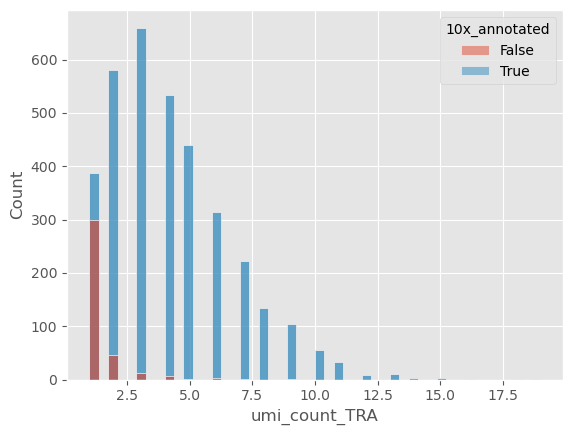

In [247]:
sns.histplot(tcr_df, x='umi_count_TRA', hue='10x_annotated')
plt.show()

# Plot
Investigate alpha and beta chains that:
* recur in multiple clonotypes
* are multiplets within a GEM

In [75]:
plt_df = pd.concat([clone1[~clone1.index.isin(clone1.index.drop_duplicates(keep=False))],
                    clone1[clone1.duplicated(subset=['genes_TRA','genes_TRB'], keep=False)]]).fillna('')

In [76]:
plt_df['freq'] = plt_df.set_index(['genes_TRA','genes_TRB']).index.map(plt_df.groupby(['genes_TRA','genes_TRB']).size())

In [79]:
plt_df.reset_index(inplace=True)

In [86]:
plt_df['num_clonotype'] = plt_df.clonotype_id.str.split('clonotype').str[1]#.astype(int)

In [88]:
dct = plt_df[plt_df.duplicated(subset=['genes_TRA','genes_TRB'], keep=False)].groupby(['genes_TRA','genes_TRB']).num_clonotype.unique().apply(lambda x: ', '.join(x))

In [90]:
plt_df['clonotype_lst'] = plt_df.set_index(['genes_TRA','genes_TRB']).index.map(dct)

In [92]:
plt_df['clonotype_lab'] = np.where(plt_df.clonotype_lst == plt_df.clonotype_lst, plt_df.clonotype_lst, plt_df.num_clonotype)

In [93]:
plt_df

,clonotype_id,genes_TRA,genes_TRB,freq,num_clonotype,clonotype_lst,clonotype_lab
0,clonotype10,CAAENQGGKLIF;TRAV29/DV5;TRAJ23,CASSERGQGAYEQYF;TRBV5-4;TRBJ2-7,1,10,NaN,10
1,clonotype10,CAASRYAGNNRKLIW;TRAV29/DV5;TRAJ38,CASSERGQGAYEQYF;TRBV5-4;TRBJ2-7,1,10,NaN,10
2,clonotype12,CAASPGGFKTIF;TRAV29/DV5;TRAJ9,CASSSPGSGASEKLFF;TRBV11-2;TRBJ1-4,1,12,NaN,12
3,clonotype12,CAVGAGSNTGKLIF;TRAV8-3;TRAJ37,CASSSPGSGASEKLFF;TRBV11-2;TRBJ1-4,1,12,NaN,12
4,clonotype125,CALIGMYSGGGADGLTF;TRAV9-2;TRAJ45,CASSPTYEQYF;TRBV19;TRBJ2-7,1,125,NaN,125
...,...,...,...,...,...,...,...
136,clonotype466,,CASSLIGVSSYNEQFF;TRBV7-9;TRBJ2-1,5,466,"455, 456, 465, 466, 467","455, 456, 465, 466, 467"
137,clonotype467,,CASSLIGVSSYNEQFF;TRBV7-9;TRBJ2-1,5,467,"455, 456, 465, 466, 467","455, 456, 465, 466, 467"
138,clonotype47,CAVRDTDARLMF;TRAV3;TRAJ31,CASSSVNEQYF;TRBV12-4;TRBJ2-7,2,47,"148, 47","148, 47"
139,clonotype512,CAAENQGGKLIF;TRAV29/DV5;TRAJ23,,2,512,"512, 513","512, 513"


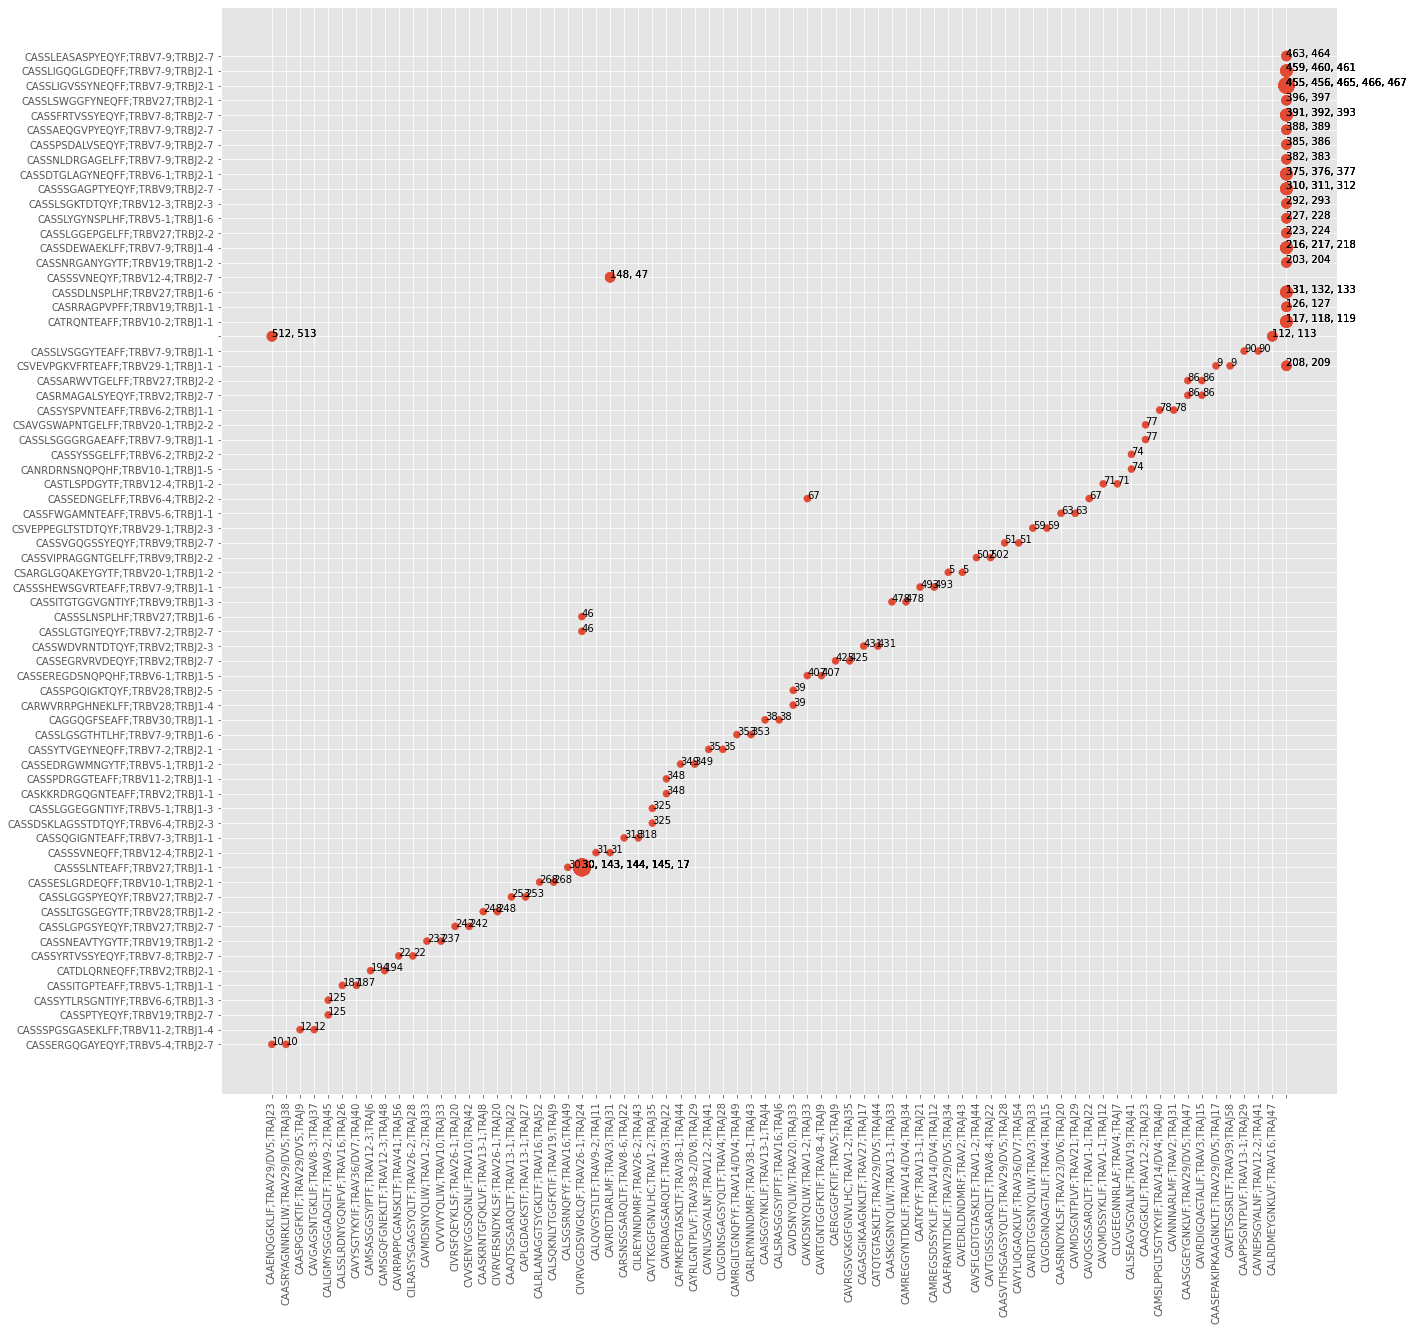

In [94]:
plt.figure(figsize=(20,20))
plt.scatter(plt_df.genes_TRA, plt_df.genes_TRB, s=plt_df.freq * 50)
plt.xticks(rotation=90)

ax = plt.gca()
for i, txt in enumerate(plt_df.clonotype_lab):
    ax.annotate(txt, (plt_df.genes_TRA[i], plt_df.genes_TRB[i]))
    
plt.show()

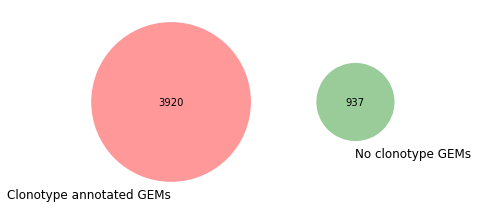

In [119]:
from matplotlib_venn import venn2

set1 = set(df[~df.clonotype.isnull()].gem.unique())
set2 = set(df[df.clonotype.isnull()].gem.unique())

venn2([set1, set2], ('Clonotype annotated GEMs', 'No clonotype GEMs'))

plt.show()

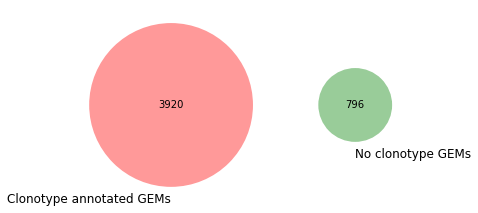

In [123]:
set1 = set(flt_df[~flt_df.clonotype.isnull()].gem.unique())
set2 = set(flt_df[flt_df.clonotype.isnull()].gem.unique())

venn2([set1, set2], ('Clonotype annotated GEMs', 'No clonotype GEMs'))

plt.show()

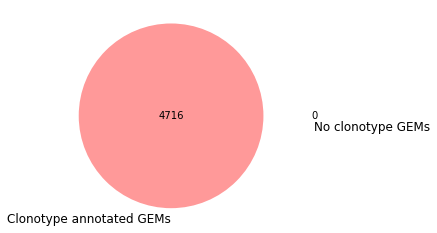

In [122]:
set1 = set(flt_df[~flt_df.ct.isnull()].gem.unique())
set2 = set(flt_df[flt_df.ct.isnull()].gem.unique())

venn2([set1, set2], ('Clonotype annotated GEMs', 'No clonotype GEMs'))

plt.show()

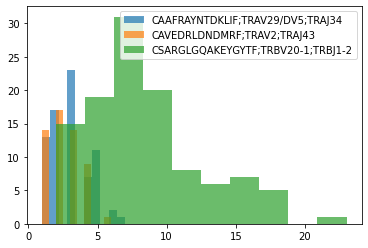

In [241]:
for i, chain in df[df.clonotype == 'clonotype5'].groupby('genes').umi_count.apply(lambda x: list(x)).items():
    plt.hist(chain, label=i, alpha=0.7)
plt.legend()
plt.show()

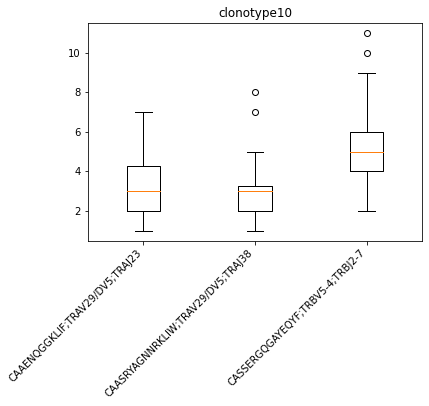

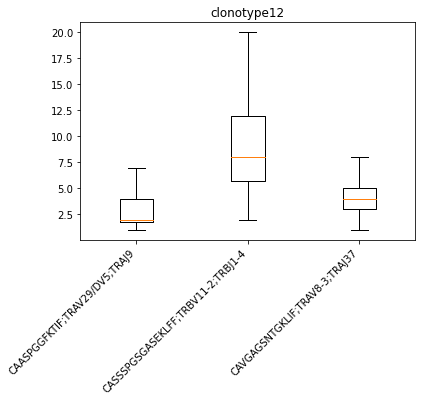

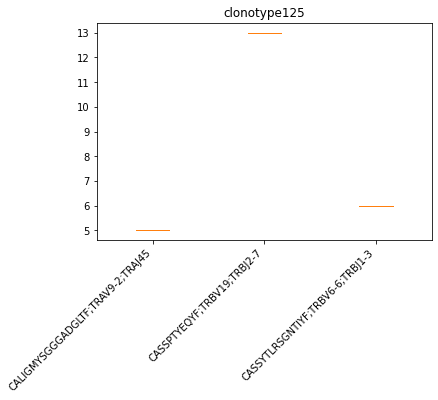

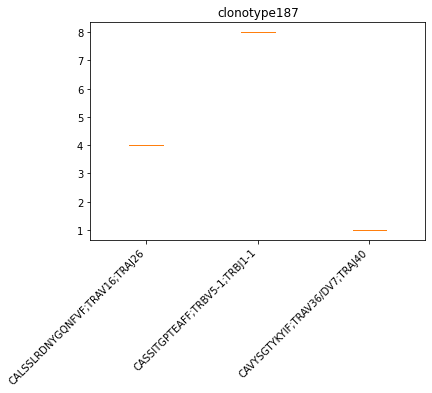

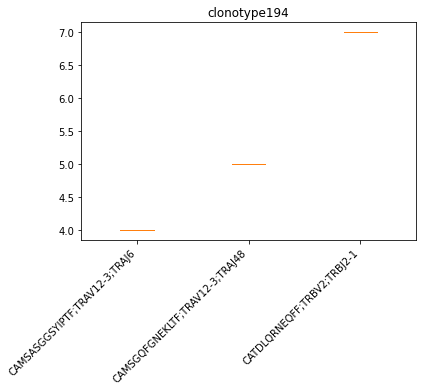

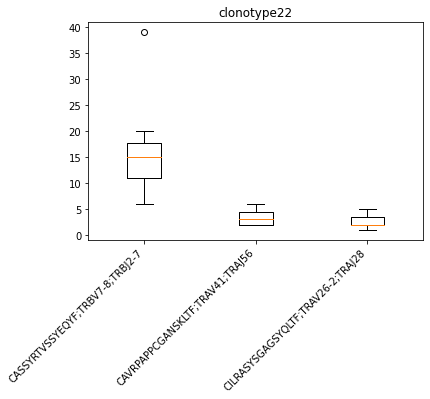

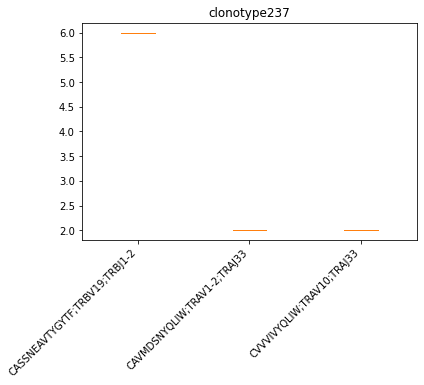

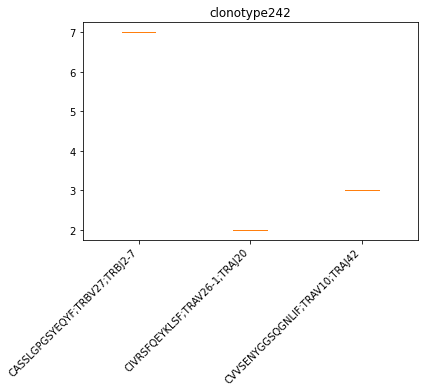

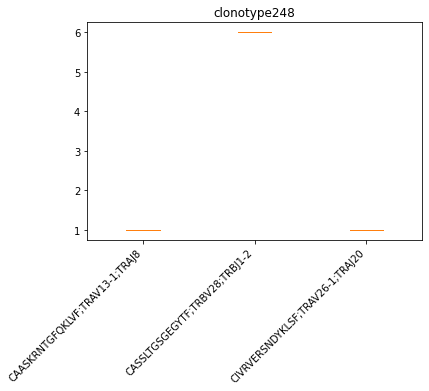

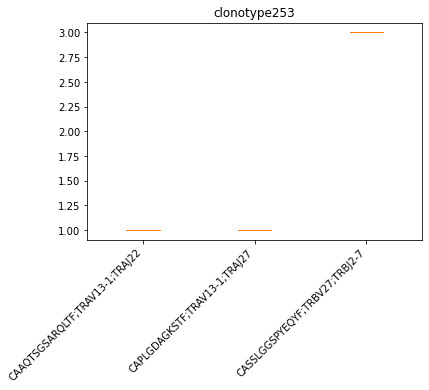

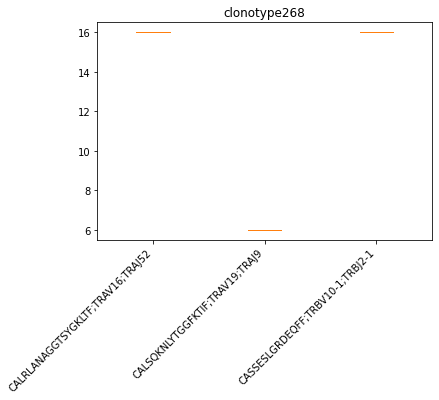

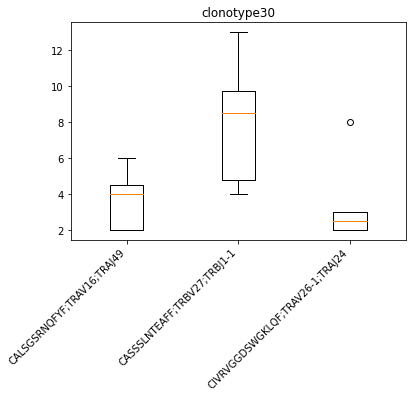

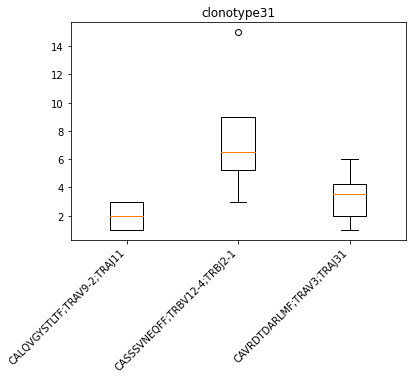

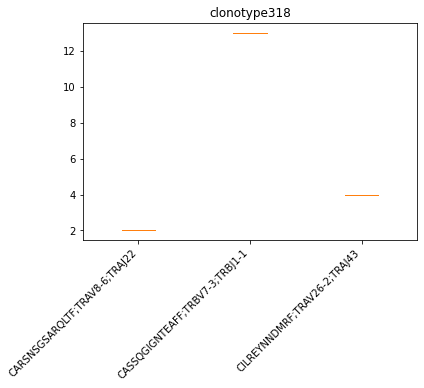

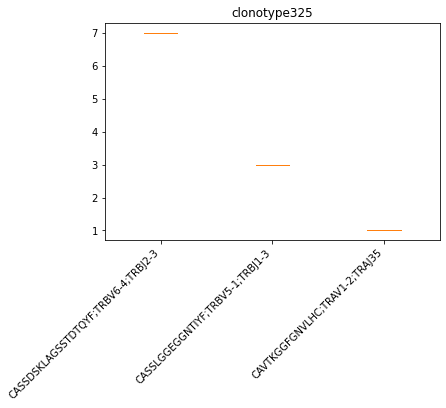

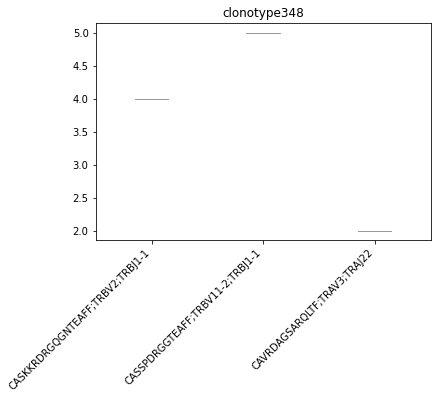

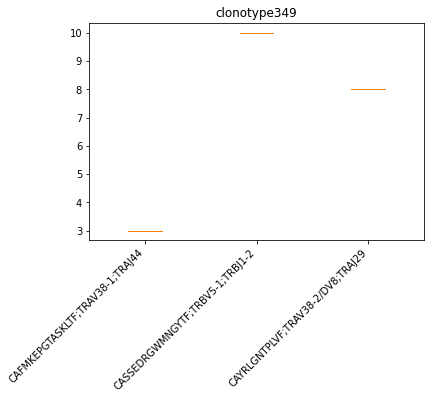

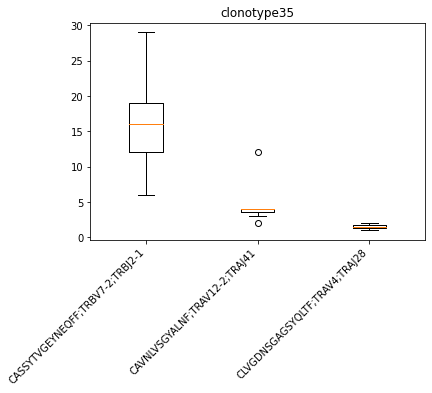

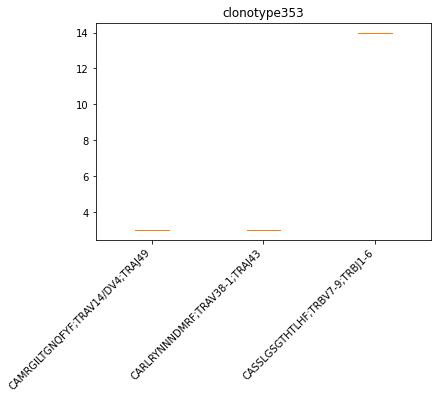

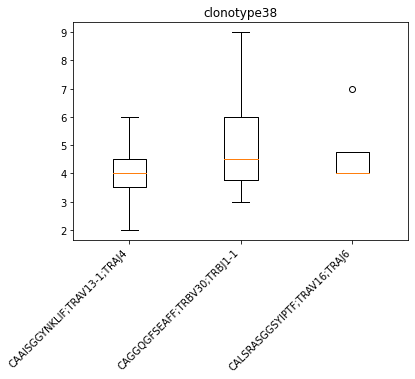

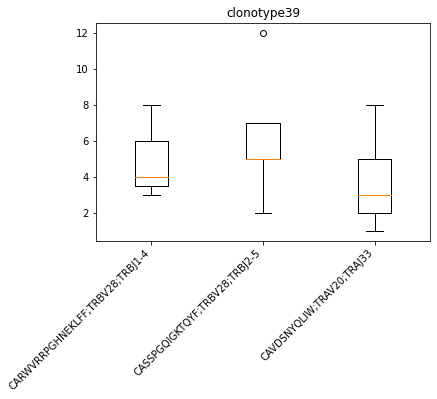

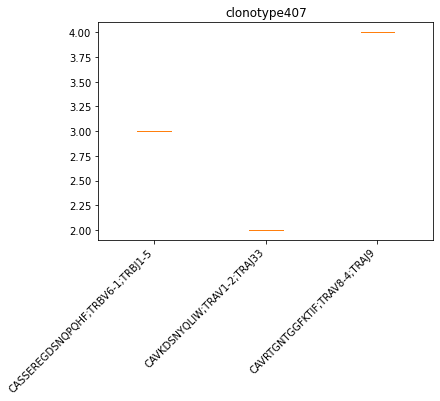

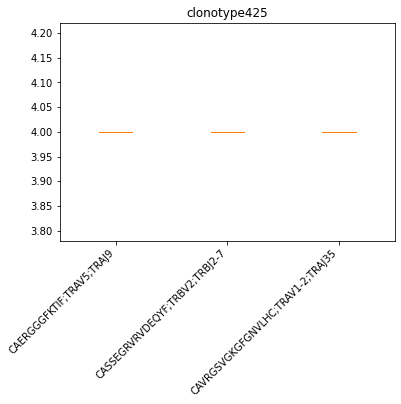

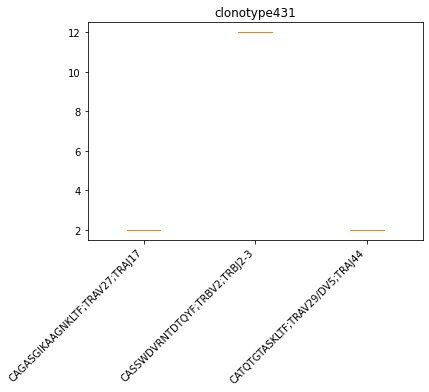

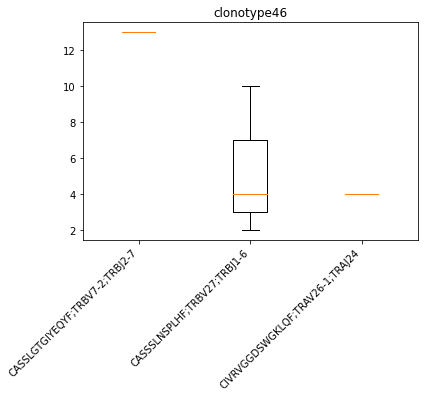

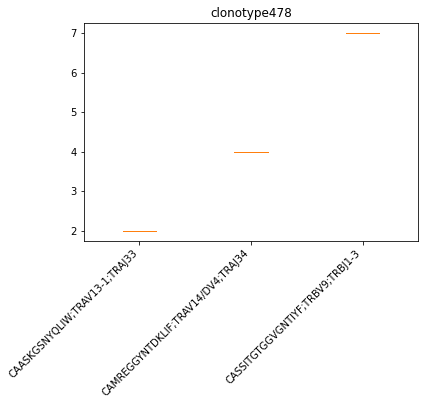

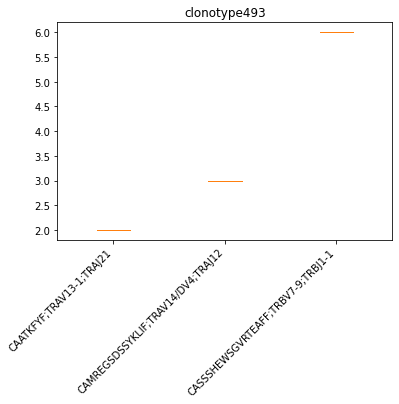

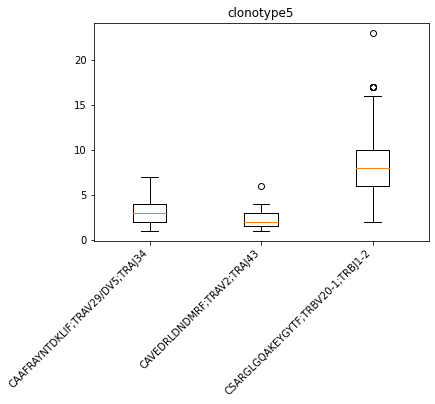

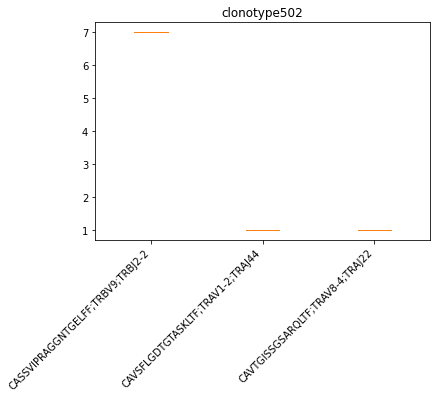

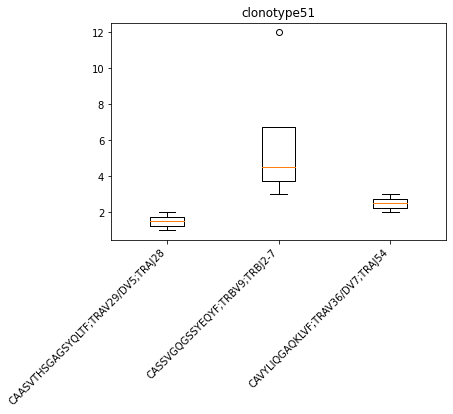

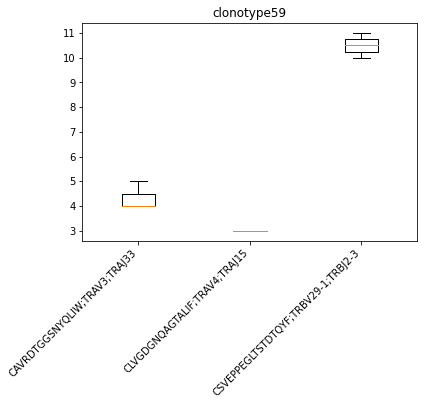

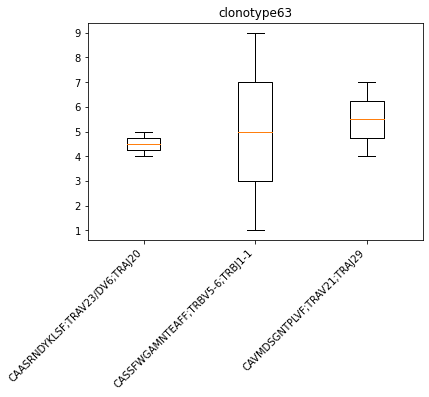

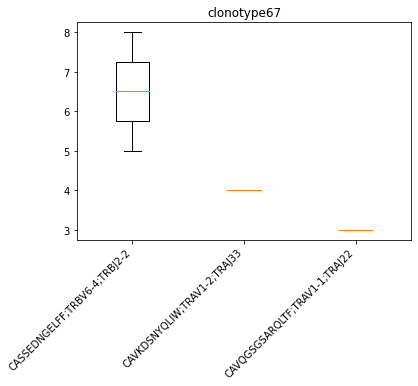

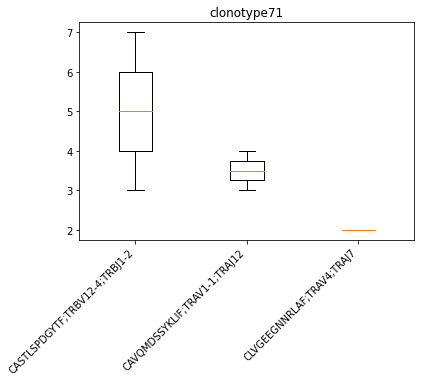

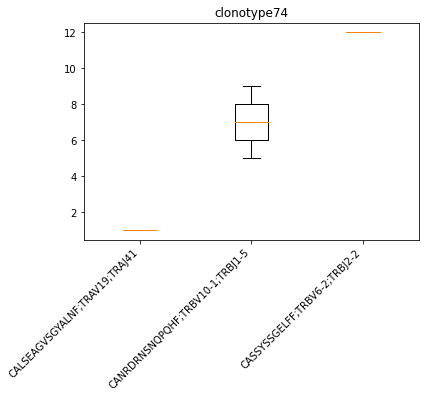

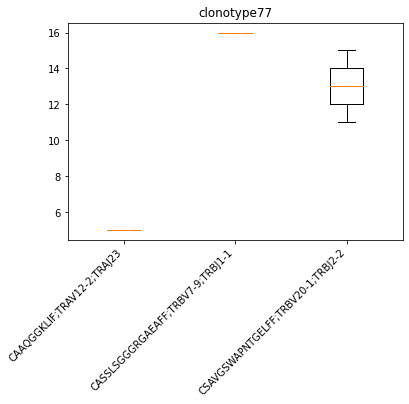

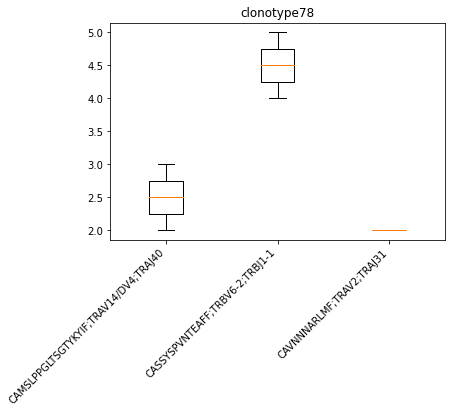

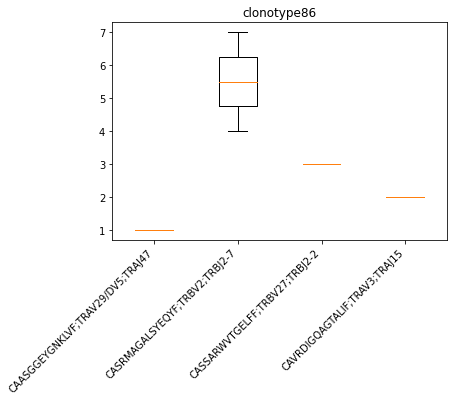

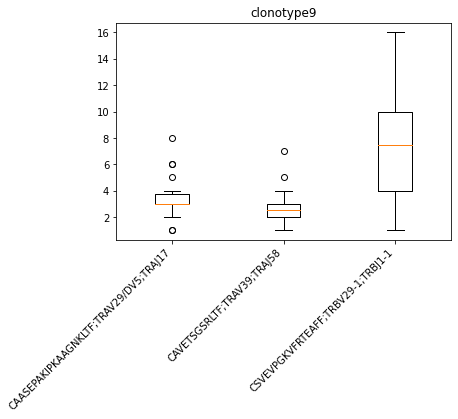

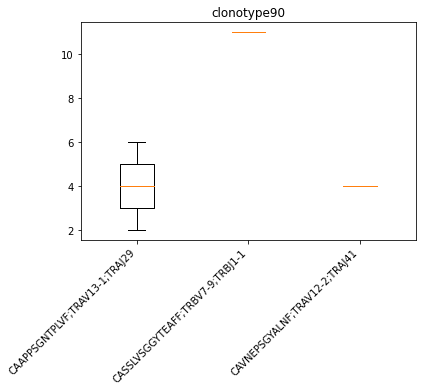

In [251]:
for clone in clone_multiplets:
    data = df[df.clonotype == clone].groupby('genes').umi_count.apply(lambda x: list(x))
    labels = data.index
    plt.boxplot(data)
    plt.xticks(np.arange(1,len(data)+1), labels, rotation=45, ha='right')
    plt.title(clone)
    plt.show()

# Testing

In [42]:
tcr_df[tcr_df['exclude_single-chain_TCRs']]

,gem,is_cell_TRA,contig_id_TRA,high_confidence_TRA,length_TRA,chain_TRA,v_gene_TRA,d_gene_TRA,j_gene_TRA,c_gene_TRA,...,single_TRB,num_clonotype,single_chain_only,umi_count_tcr,cdr3_comb,tcr_category,no_filtration,exclude_single-chain_TCRs,exclude_ambiguous_and_single-chain_TCRs,ct
0,AAACCTGAGAATTGTG-1,True,AAACCTGAGAATTGTG-1_contig_1,True,548.0,TRA,TRAV29DV5,None,TRAJ45,TRAC,...,True,2,False,27.0,CAAKSDSGGGADGLTFCASSAWTSNRDEQFF,unique chains,True,True,True,3
1,AAACCTGAGACTAGGC-1,True,AAACCTGAGACTAGGC-1_contig_3,True,525.0,TRA,TRAV27,None,TRAJ28,TRAC,...,True,3,False,12.0,CAGARSYQLTFCASSPLSLNTEAFF,unique chains,True,True,True,6
2,AAACCTGAGAGTCTGG-1,True,AAACCTGAGAGTCTGG-1_contig_2,True,692.0,TRA,TRAV8-6,None,TRAJ41,TRAC,...,True,29,False,95.0,CAVSSNSNSGYALNFCASSFDRDEQYF,unique chains,True,True,True,52
3,AAACCTGAGGCCGAAT-1,True,AAACCTGAGGCCGAAT-1_contig_4,True,584.0,TRA,TRAV12-2,None,TRAJ23,TRAC,...,False,519,False,43.0,CAAQGGKLIFCASSFQGAETQYF,multiple chains,True,True,False,2371
5,AAACCTGAGTTCGATC-1,True,AAACCTGAGTTCGATC-1_contig_2,True,542.0,TRA,TRAV14DV4,None,TRAJ9,TRAC,...,True,9,False,8.0,CALNTGGFKTIFCASSPPFLAGSGSSYEQYF,unique chains,True,True,True,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,TTTGTCAGTGCAGGTA-1,True,TTTGTCAGTGCAGGTA-1_contig_2,True,543.0,TRA,TRAV13-1,None,TRAJ45,TRAC,...,True,73,False,11.0,CAASWRPDSGGGADGLTFCSASKREVWNIQYF,unique chains,True,True,True,155
7510,TTTGTCAGTGGAAAGA-1,True,TTTGTCAGTGGAAAGA-1_contig_1,True,581.0,TRA,TRAV29DV5,None,TRAJ45,TRAC,...,True,2,False,14.0,CAAKSDSGGGADGLTFCASSAWTSNRDEQFF,unique chains,True,True,True,3
7511,TTTGTCATCAACGGCC-1,True,TTTGTCATCAACGGCC-1_contig_2,True,521.0,TRA,TRAV27,None,TRAJ28,TRAC,...,True,3,False,12.0,CAGARSYQLTFCASSPLSLNTEAFF,unique chains,True,True,True,6
7513,TTTGTCATCGACAGCC-1,True,TTTGTCATCGACAGCC-1_contig_4,True,572.0,TRA,TRAV29DV5,None,TRAJ40,TRAC,...,True,24,False,142.0,CAASFSGTYKYIFCASSLVAYNEQFF,unique chains,True,True,True,47


In [46]:
import re
regex = re.findall('unique_tcrs', 'lalalalaldkfjaoiwe/unique_tcrs/asdf')
if regex:
    print(regex)
else:
    print('nothing')

['unique_tcrs']


In [53]:
tcr_df.groupby(['v_gene_TRA','d_gene_TRA','j_gene_TRA','c_gene_TRA',
                'v_gene_TRB','d_gene_TRB','j_gene_TRB','c_gene_TRB',
                'cdr3_comb']).clonotype.unique().to_frame()#.to_csv("/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_TCR/augmented/tcr.clonotypes.csv")

clonotype
v_gene_TRA d_gene_TRA j_gene_TRA c_gene_TRA v_gene_TRB d_gene_TRB j_gene_TRB c_gene_TRB cdr3_comb                                        
TRAV1-1    None       TRAJ36     TRAC       TRBV2      TRBD1      TRBJ2-5    TRBC2      CAVTPGANNLFFCASSEATGTGETQYF         [clonotype19]
                      TRAJ4      TRAC       unknown    unknown    unknown    unknown    CAVAGGYNKLIF                               [None]
TRAV1-2    None       TRAJ12     TRAC       TRBV6-3    TRBD1      TRBJ2-3    TRBC2      CAVVDSSYKLIFCASSSPPGEGSDTQYF        [clonotype41]
                                            TRBV6-4    TRBD2      TRBJ2-1    TRBC2      CAVMDSSYKLIFCASSDSSGGASEQFF        [clonotype103]
                      TRAJ15     TRAC       unknown    unknown    unknown    unknown    CAVRDTQAGTALIF                             [None]
...                                                                                                                                   ...
unknown    unknown    unknown    unknown    TRBV7-9    TRBD2      TRBJ2-1    TRBC2      CASGGGEEYNEQFF                             [None]
                                                                                        CASSQIGEGHGDEQFF              [None, clonotype11]
                                            TRBV9      None       TRBJ2-3    TRBC2      CASSPSDILADTQYF                     [clonotype97]
                                                       TRBD1      TRBJ1-6    TRBC1      CASSEGQGNSPLHF                     [clonotype106]
                                                       TRBD2      TRBJ2-1    TRBC2      CASSEATSGISYNEQFF                          [None]

[241 rows x 1 columns]

In [56]:
tcr_df.ct.unique().shape

(241,)

In [44]:
tcr_df.drop(tcr_df[~tcr_df.duplicated(subset='clonotype', keep=False)].index).clonotype

2       None
3       None
4       None
5       None
6       None
        ... 
5418    None
5419    None
5420    None
5421    None
5422    None
Name: clonotype, Length: 5332, dtype: object

In [79]:
tcr_df[(tcr_df.num_clonotype!=1) & (tcr_df.ct==1)].iloc[:,25:]# & (tcr_df.ct==2)

,length_TRB,chain_TRB,v_gene_TRB,d_gene_TRB,j_gene_TRB,c_gene_TRB,full_length_TRB,productive_TRB,cdr3_TRB,cdr3_nt_TRB,...,chain_count_TRB,umi_count_lst_TRB,cdr3_lst_TRB,single_TRB,num_clonotype,single_chain_only,single_tcell,umi_count_tcr,cdr3_comb,ct
7515,464.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,1
7526,477.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,2.0,"[1, 1]","[CASSFSGSTDTQYF, CASSAWTSNRDEQFF]",False,0,True,False,1.0,CASSAWTSNRDEQFF,1
7529,536.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[6],[CASSAWTSNRDEQFF],True,0,True,False,6.0,CASSAWTSNRDEQFF,1
7535,480.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[2],[CASSAWTSNRDEQFF],True,0,True,False,2.0,CASSAWTSNRDEQFF,1
7541,477.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13376,491.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[4],[CASSAWTSNRDEQFF],True,0,True,False,4.0,CASSAWTSNRDEQFF,1
13378,493.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,1
13385,499.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,2.0,"[1, 1]","[CASEFSETQYF, CASSAWTSNRDEQFF]",False,0,True,False,1.0,CASSAWTSNRDEQFF,1
13386,480.0,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,True,CASSAWTSNRDEQFF,TGTGCCAGCAGCGCCTGGACTAGTAATCGGGATGAGCAGTTCTTC,...,1.0,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,1


In [41]:
tcr_df[(tcr_df.num_clonotype==1) & (tcr_df.ct!='c2')].iloc[:,25:]

,length_TRB,chain_TRB,v_gene_TRB,d_gene_TRB,j_gene_TRB,c_gene_TRB,full_length_TRB,productive_TRB,cdr3_TRB,cdr3_nt_TRB,...,chain_count_TRB,umi_count_lst_TRB,cdr3_lst_TRB,single_TRB,num_clonotype,single_chain_only,single_tcell,umi_count_tcr,cdr3_comb,ct
1453,690,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,3,"[1, 4, 35]","[CASRPRVAGGRNEQFF, CASSAWTSNRDEQFF, CASRPRVAGG...",False,1,False,False,49.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
1888,699,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,2,"[2, 53]","[CASRPRVAGGRNEQFF, CASRPRVAGGRNEQFF]",False,1,False,False,85.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
1954,700,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,2,"[1, 39]","[CASRPRVAGGRNEQFF, CASRPRVAGGRNEQFF]",False,1,False,False,71.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
2125,699,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,1,[66],[CASRPRVAGGRNEQFF],True,1,False,True,148.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
2470,693,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,2,"[4, 57]","[CASSQDLLANEQFF, CASRPRVAGGRNEQFF]",False,1,False,False,90.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
2921,693,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,2,"[8, 74]","[CASSSTKAGNQPQHF, CASRPRVAGGRNEQFF]",False,1,False,False,127.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
3515,693,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,1,[38],[CASRPRVAGGRNEQFF],True,1,False,True,56.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
3612,595,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,1,[36],[CASRPRVAGGRNEQFF],True,1,False,True,61.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
4024,695,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,1,[35],[CASRPRVAGGRNEQFF],True,1,False,True,67.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122
4469,691,TRB,TRBV12-4,TRBD2,TRBJ2-1,TRBC1,True,True,CASRPRVAGGRNEQFF,TGTGCCAGCAGACCCAGAGTAGCGGGAGGGCGCAATGAGCAGTTCTTC,...,1,[49],[CASRPRVAGGRNEQFF],True,1,False,True,70.0,CAVRSAYSGAGSYQLTFCASRPRVAGGRNEQFF,c122


In [60]:
tcr_df[(tcr_df.ct == 'c1') & (tcr_df.num_clonotype==11)].iloc[:,22:]

,is_cell_TRB,contig_id_TRB,high_confidence_TRB,length_TRB,chain_TRB,v_gene_TRB,d_gene_TRB,j_gene_TRB,c_gene_TRB,full_length_TRB,...,chain_count_TRB,umi_count_lst_TRB,cdr3_lst_TRB,single_TRB,num_clonotype,single_chain_only,single_tcell,umi_count_tcr,cdr3_comb,ct
7732,True,AAGGCAGGTATAGGTA-1_contig_1,True,555,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[10],[CASSAWTSNRDEQFF],True,11,True,False,10.0,CASSAWTSNRDEQFF,c1
7770,True,AATCCAGAGAAACCTA-1_contig_1,True,545,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,2,"[1, 16]","[CASRPRVAGGRNEQFF, CASSAWTSNRDEQFF]",False,11,True,False,16.0,CASSAWTSNRDEQFF,c1
8132,True,ACTGATGTCAACACCA-1_contig_2,True,500,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[4],[CASSAWTSNRDEQFF],True,11,True,False,4.0,CASSAWTSNRDEQFF,c1
8368,True,AGCTTGAGTGTCCTCT-1_contig_1,True,500,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[5],[CASSAWTSNRDEQFF],True,11,True,False,5.0,CASSAWTSNRDEQFF,c1
8560,True,ATAACGCCACGAAAGC-1_contig_1,True,526,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[8],[CASSAWTSNRDEQFF],True,11,True,False,8.0,CASSAWTSNRDEQFF,c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13117,True,TTAACTCAGTGTACCT-1_contig_1,True,500,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[8],[CASSAWTSNRDEQFF],True,11,True,False,8.0,CASSAWTSNRDEQFF,c1
13267,True,TTCTTAGGTGGCAAAC-1_contig_1,True,501,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[8],[CASSAWTSNRDEQFF],True,11,True,False,8.0,CASSAWTSNRDEQFF,c1
13298,True,TTGCCGTAGCTAGCCC-1_contig_1,True,539,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[9],[CASSAWTSNRDEQFF],True,11,True,False,9.0,CASSAWTSNRDEQFF,c1
13325,True,TTGCGTCTCTCCAACC-1_contig_2,True,500,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,2,"[1, 8]","[CASSLNLGDRSDEQFF, CASSAWTSNRDEQFF]",False,11,True,False,8.0,CASSAWTSNRDEQFF,c1


In [59]:
tcr_df[(tcr_df.ct == 'c1') & (tcr_df.num_clonotype!=11)].iloc[:,22:]

,is_cell_TRB,contig_id_TRB,high_confidence_TRB,length_TRB,chain_TRB,v_gene_TRB,d_gene_TRB,j_gene_TRB,c_gene_TRB,full_length_TRB,...,chain_count_TRB,umi_count_lst_TRB,cdr3_lst_TRB,single_TRB,num_clonotype,single_chain_only,single_tcell,umi_count_tcr,cdr3_comb,ct
7515,False,AAACCTGAGACTGTAA-1_contig_1,True,464,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,c1
7526,False,AAACCTGTCAGAGACG-1_contig_2,False,477,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,2,"[1, 1]","[CASSFSGSTDTQYF, CASSAWTSNRDEQFF]",False,0,True,False,1.0,CASSAWTSNRDEQFF,c1
7529,False,AAACGGGAGCGTGAAC-1_contig_1,True,536,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[6],[CASSAWTSNRDEQFF],True,0,True,False,6.0,CASSAWTSNRDEQFF,c1
7535,False,AAACGGGGTAGGGACT-1_contig_1,True,480,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[2],[CASSAWTSNRDEQFF],True,0,True,False,2.0,CASSAWTSNRDEQFF,c1
7541,False,AAAGATGCACCAACCG-1_contig_1,True,477,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13376,False,TTTCCTCGTAATTGGA-1_contig_1,True,491,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[4],[CASSAWTSNRDEQFF],True,0,True,False,4.0,CASSAWTSNRDEQFF,c1
13378,False,TTTCCTCGTTCGCTAA-1_contig_1,True,493,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,c1
13385,False,TTTGCGCAGGCAGTCA-1_contig_2,False,499,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,2,"[1, 1]","[CASEFSETQYF, CASSAWTSNRDEQFF]",False,0,True,False,1.0,CASSAWTSNRDEQFF,c1
13386,False,TTTGCGCAGTTACCCA-1_contig_1,True,480,TRB,TRBV9,TRBD2,TRBJ2-1,TRBC2,True,...,1,[1],[CASSAWTSNRDEQFF],True,0,True,False,1.0,CASSAWTSNRDEQFF,c1


In [61]:
tcr_df.groupby('cdr3_comb').clonotype.unique()

cdr3_comb
CAAAETSYDKVIFCASRVGEANYGYTF                         [clonotype2245]
CAAAETSYDKVIFCASSSTGAGNQPQHF                         [clonotype354]
CAAAMDSNYQLIWCASSLIGGGTEAFF                          [clonotype842]
CAAANAGGTSYGKLTF                                             [None]
CAAANAGGTSYGKLTFCASSLGQFYEQYF         [clonotype1015, clonotype307]
                                                ...                
CVYNQGGKLIF                                   [None, clonotype1235]
CVYNQGGKLIFCASSPPGTVSSYEQYF                         [clonotype2219]
CVYNQGGKLIFCASSQARDPTGELFF       [clonotype42, None, clonotype1758]
CWPRSNYQLIWCASSQGLAGGYEQYF                                   [None]
CYPIPRHDTVYCLLGTSGTGNEQFF                                    [None]
Name: clonotype, Length: 3295, dtype: object

In [67]:
tcr_df[tcr_df.cdr3_comb == 'CAAANAGGTSYGKLTFCASSLGQFYEQYF'].iloc[:,12:]

,cdr3_TRA,cdr3_nt_TRA,read_count_TRA,umi_count_TRA,clonotype,raw_consensus_id_TRA,chain_count_TRA,umi_count_lst_TRA,cdr3_lst_TRA,single_TRA,...,chain_count_TRB,umi_count_lst_TRB,cdr3_lst_TRB,single_TRB,num_clonotype,single_chain_only,single_tcell,umi_count_tcr,cdr3_comb,ct
1664,CAAANAGGTSYGKLTF,TGTGCCGCCGCTAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,1678,16,clonotype1015,clonotype1015_consensus_4,4,"[1, 5, 11, 16]","[CAAANAGGTSYGKLTF, CAVDNAGNMLTF, CAPRYGGSQGNLI...",False,...,2,"[13, 17]","[CSAPTPAGTLVWETQYF, CASSLGQFYEQYF]",False,1015,False,False,33.0,CAAANAGGTSYGKLTFCASSLGQFYEQYF,c599
7408,CAAANAGGTSYGKLTF,TGTGCCGCCGCTAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,3457,36,clonotype307,clonotype307_consensus_3,2,"[33, 36]","[CAPRYGGSQGNLIF, CAAANAGGTSYGKLTF]",False,...,1,[43],[CASSLGQFYEQYF],True,307,False,True,79.0,CAAANAGGTSYGKLTFCASSLGQFYEQYF,c599
7504,CAAANAGGTSYGKLTF,TGTGCCGCCGCTAATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,2358,27,clonotype307,clonotype307_consensus_3,2,"[11, 27]","[CAPRYGGSQGNLIF, CAAANAGGTSYGKLTF]",False,...,1,[32],[CASSLGQFYEQYF],True,307,False,True,59.0,CAAANAGGTSYGKLTFCASSLGQFYEQYF,c599


In [76]:
tcr_df[(tcr_df.single_TRA == True) & (tcr_df.single_TRB == True)].ct.unique().tolist()

['c3',
 'c6',
 'c52',
 'c25',
 'c150',
 'c407',
 'c21',
 'c746',
 'c1460',
 'c3062',
 'c386',
 'c2',
 'c3057',
 'c87',
 'c2724',
 'c1077',
 'c2978',
 'c10',
 'c3248',
 'c2211',
 'c296',
 'c339',
 'c36',
 'c115',
 'c1936',
 'c320',
 'c100',
 'c2732',
 'c162',
 'c1117',
 'c119',
 'c596',
 'c632',
 'c426',
 'c482',
 'c1094',
 'c1762',
 'c551',
 'c1909',
 'c2711',
 'c310',
 'c794',
 'c3297',
 'c904',
 'c2802',
 'c28',
 'c1238',
 'c648',
 'c83',
 'c1780',
 'c58',
 'c328',
 'c7',
 'c1607',
 'c61',
 'c795',
 'c15',
 'c2970',
 'c218',
 'c1484',
 'c3046',
 'c291',
 'c1363',
 'c2786',
 'c172',
 'c14',
 'c1310',
 'c785',
 'c114',
 'c650',
 'c160',
 'c37',
 'c158',
 'c2265',
 'c81',
 'c139',
 'c1745',
 'c561',
 'c1815',
 'c509',
 'c47',
 'c796',
 'c563',
 'c1088',
 'c180',
 'c1001',
 'c352',
 'c1834',
 'c226',
 'c1139',
 'c720',
 'c492',
 'c71',
 'c2973',
 'c1145',
 'c102',
 'c2909',
 'c175',
 'c1843',
 'c1265',
 'c248',
 'c652',
 'c628',
 'c355',
 'c273',
 'c1525',
 'c862',
 'c1104',
 'c101',
 'c

In [73]:
tcr_df.shape

(13418, 48)